In [1]:
import cmasher as cmr

import scienceplots
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

import cmbo
from IPython.display import display

from plot_stacked import *

%load_ext autoreload
%autoreload 2

/Users/rstiskalek/Projects/CMBOlympics/venv_cmbolympics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Single simulation results file

In [ ]:
fname = "/Users/rstiskalek/Projects/cmbo/results/csiborg2.hdf5"
res = cmbo.io.TSZMassBinResults(fname, True)

### Significance per mass bins

In [ ]:
fig, ax = plot_mass_bin_pvalues(res)
fig.savefig("/Users/rstiskalek/Downloads/pvals.png", dpi=450)

display(fig)


### Stacked 1D profiles per mass bin

In [ ]:
fig, axs = plot_stacked_profiles(res, nbins=3, simulation=None)
fig.savefig("/Users/rstiskalek/Downloads/stacked.png", dpi=450)

display(fig)

### Stacked 2D profiles per mass bin

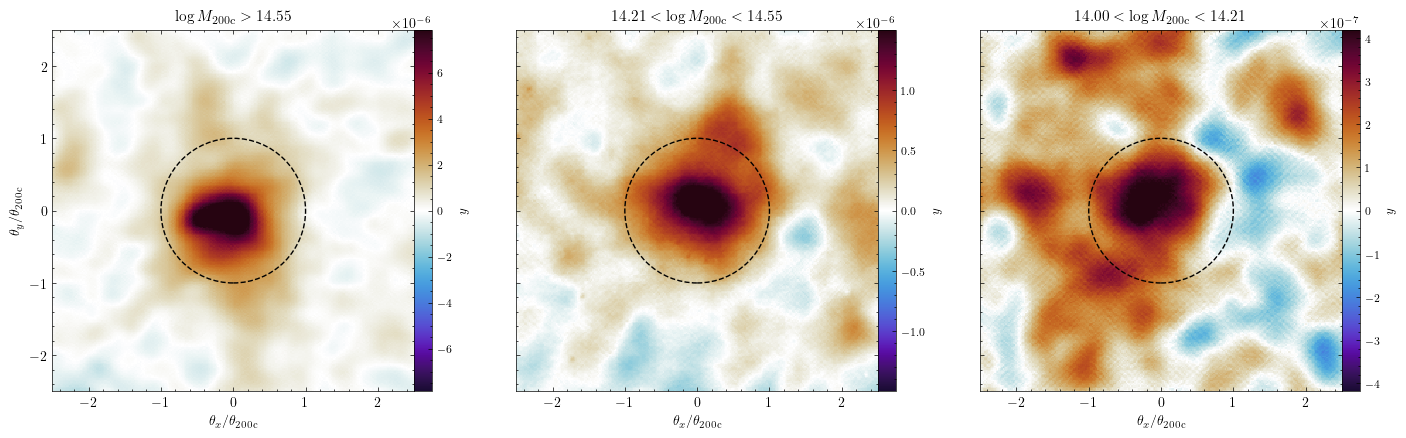

In [ ]:
fig, axs = plot_cutout_maps(res, nbins=3, mode="stack", simulation=None, cmap=cmr.fusion_r)
fig.savefig("/Users/rstiskalek/Downloads/project.png", dpi=450)
display(fig)

## development

In [2]:
fname = "../data/csiborg2_fof.hdf5"

positions, masses = cmbo.io.load_halo_positions_masses(fname, "Coordinates", "Group_M_Crit200")

In [ ]:
associations = cmbo.utils.identify_halo_associations(positions, masses,)

fname_clusters = "/Users/rstiskalek/Projects/cmbo/data/observed_cluster_masses.toml"
obs_clusters = cmbo.io.load_observed_clusters(fname_clusters)

In [16]:
pval, dist = cmbo.utils.compute_matching_matrix(obs_clusters, associations, 676.6)

100%|██████████| 358/358 [00:01<00:00, 179.17it/s]

Perseus (A426): min p-value = 9.167e-01


In [17]:
matches = cmbo.utils.greedy_global_matching(pval, dist, obs_clusters, associations, 0.05)

Cluster 17 (Shapley (A3562)) now orphaned (best remaining p=9.335e-02)
Cluster 18 (Perseus (A426)) now orphaned (best remaining p=9.167e-01)
Cluster 8 (Hercules (A2147)) now orphaned (best remaining p=1.303e-01)


In [92]:
obs_clusters.names

['Abell 1644',
 'Abell 119',
 'Abell 548',
 'Abell 1736',
 'Abell 496',
 'Hydra (A1060)',
 'Centaurus (A3526)',
 'Hercules (A2199)',
 'Hercules (A2147)',
 'Hercules (A2063)',
 'Hercules (A2151)',
 'Leo (A1367)',
 'Coma (A1656)',
 'Norma (A3627)',
 'Virgo Cluster',
 'Shapley (A3571)',
 'Shapley (A3558)',
 'Shapley (A3562)',
 'Perseus (A426)']

In [110]:
k = 1

print(obs_clusters.names[k])

assoc, min_pval, d = matches[k]

print(f"p-value: {min_pval:.3e}, distance: {d:.2f} Mpc")

Abell 119
p-value: 7.696e-04, distance: 2.90 Mpc


In [111]:
assoc

HaloAssociation(label=8, centroid=array([460.36136932, 368.69997711, 335.57730255]), positions=array([[459.87591553, 368.86358643, 335.51702881],
       [460.56054688, 368.81109619, 336.09481812],
       [460.94091797, 368.27661133, 335.85406494],
       [460.2817688 , 368.45065308, 334.96212769],
       [460.13259888, 368.14016724, 335.64877319],
       [460.26507568, 368.7401123 , 335.23504639],
       [459.73171997, 368.55282593, 334.92984009],
       [459.95373535, 368.69946289, 335.42572021],
       [460.20349121, 368.70895386, 335.06259155],
       [459.83267212, 368.79220581, 335.13742065],
       [460.09487915, 368.87811279, 336.08041382],
       [461.31866455, 369.25527954, 335.64892578],
       [459.68624878, 368.70843506, 335.87350464],
       [459.56887817, 368.61001587, 335.90878296],
       [459.77890015, 368.90472412, 335.68099976],
       [459.89199829, 368.66381836, 335.85751343],
       [461.11459351, 368.74343872, 335.61758423],
       [461.46630859, 368.27633667, 33

In [112]:
obs_pos = np.full((3,), 676.6 / 2)
r, ell, b = assoc.to_galactic_angular(obs_pos)

rc, ellc, bc = assoc.centroid_to_galactic_angular(obs_pos)

In [ ]:
fname = "/Users/rstiskalek/Projects/cmbo/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
cmb_tsz = cmbo.io.read_Planck_comptonSZ(fname)
cmb_tsz = cmbo.utils.smooth_map_gaussian(cmb_tsz, fwhm_arcmin=9.6, )

In [ ]:
cutout_gen = cmbo.corr.Pointing2DCutout(cmb_tsz, )

size_arcmin = 180

cut, ext = cutout_gen.get_cutout_2d(ell_deg=ellc, b_deg=bc, size_arcmin=size_arcmin)

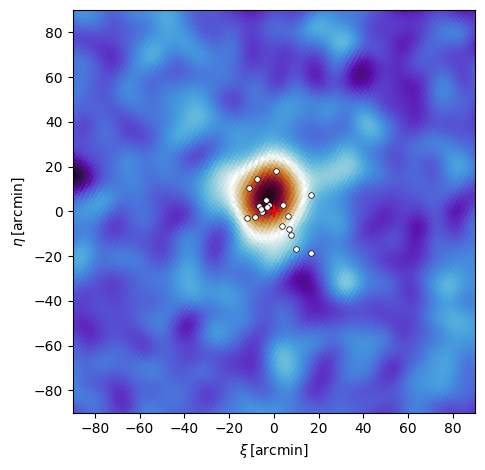

In [109]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr

def tangent_offsets_arcmin(ell_deg, b_deg, ellc_deg, bc_deg):
    c   = SkyCoord(l=np.asarray(ell_deg)*u.deg,
                   b=np.asarray(b_deg)*u.deg, frame="galactic")
    ctr = SkyCoord(l=float(ellc_deg)*u.deg,
                   b=float(bc_deg)*u.deg, frame="galactic")
    off = c.transform_to(ctr.skyoffset_frame())
    x = off.lon.wrap_at(180*u.deg).to_value(u.arcmin)
    y = off.lat.to_value(u.arcmin)
    return x, y

# --- usage ---
# cut, ext = get_cutout_2d(ellc, bc, size_arcmin)   # ext is in arcmin
x_arcmin, y_arcmin = tangent_offsets_arcmin(ell, b, ellc, bc)

plt.imshow(cut, origin="lower", extent=ext, cmap=cmr.fusion_r, aspect="equal")
plt.scatter(x_arcmin, y_arcmin, s=16, c="w", edgecolor="k", lw=0.5, zorder=3)
plt.scatter(0.0, 0.0, marker="+", c="r", s=64, zorder=4)
plt.xlabel(r'$\xi\,[\mathrm{arcmin}]$')
plt.ylabel(r'$\eta\,[\mathrm{arcmin}]$')
plt.tight_layout()
plt.savefig("/Users/rstiskalek/Downloads/cutout_Coma.png", dpi=450)
plt.show()

In [ ]:




x_obs_clusters = obs_clusters.icrs_cartesian()

assoc = associations[30]
halo_pos = assoc.positions - 676.6 / 2
np.linalg.norm(halo_pos, axis=1), np.log10(assoc.masses)

assoc = associations[30]
halo_pos = assoc.positions - 676.6 / 2
np.linalg.norm(halo_pos, axis=1), np.log10(assoc.masses)


matcher = cmbo.utils.MatchingProbability(halo_pos, np.log10(assoc.masses), )


# Here declare as a match whatever has the average p-value below a certain thhreshold

for i in range(len(x_obs_clusters)):
    pval, __, __ = matcher.cdf_per_halo(x_obs_clusters[i])
    print(i, obs_clusters.names[i], pval)

In [ ]:
assoc = associations[30]
halo_pos = assoc.positions - 676.6 / 2
np.linalg.norm(halo_pos, axis=1), np.log10(assoc.masses)

(array([10.52736642, 11.50380751,  9.84307473,  9.92548735, 10.27957835,
        10.27732594,  9.94105261, 10.22137821, 10.2377209 , 10.43631769,
        10.96019533, 10.91411393, 10.04652826, 10.61657901, 11.00300418,
        10.63284749, 11.77252973]),
 array([14.22950885, 13.92991909, 14.1893379 , 14.19553573, 14.16715122,
        14.11890332, 14.15821781, 14.23013007, 14.30109338, 14.3236154 ,
        14.14174542, 14.18468821, 14.26689869, 14.02420605, 14.24223253,
        14.23399674, 14.12827137]))

In [ ]:
obs_clusters.names

['Abell 1644',
 'Abell 119',
 'Abell 548',
 'Abell 1736',
 'Abell 496',
 'Hydra (A1060)',
 'Centaurus (A3526)',
 'Hercules (A2199)',
 'Hercules (A2147)',
 'Hercules (A2063)',
 'Hercules (A2151)',
 'Leo (A1367)',
 'Coma (A1656)',
 'Norma (A3627)',
 'Virgo Cluster',
 'Shapley (A3571)',
 'Shapley (A3558)',
 'Shapley (A3562)',
 'Perseus (A426)']

In [ ]:
x_obs_clusters#[15]

array([[-132.0864813 ,  -33.64489542,  -42.71585334],
       [ 124.82008276,   31.29763915,   -2.73299753],
       [   6.24474978,  110.22054813,  -52.93222369],
       [-112.98896682,  -45.02088897,  -62.46361744],
       [  35.00243014,   88.45114707,  -22.41504041],
       [ -33.52920105,   12.75385037,  -18.69372808],
       [ -24.91888136,   -5.38746301,  -22.40369957],
       [ -27.0828163 ,  -64.29654546,   57.61149579],
       [ -51.82416683,  -91.89025118,   30.29056111],
       [ -65.9532584 ,  -80.74509118,   15.84081952],
       [ -49.96460874,  -91.30937137,   33.31518604],
       [ -64.34875772,    4.32809567,   23.16706116],
       [ -63.30281109,  -16.90635741,   34.81010083],
       [ -10.68617936,  -21.52127383,  -43.11475109],
       [ -15.81802728,   -2.13786117,    3.49102754],
       [ -88.82507512,  -45.00182116,  -64.29368054],
       [-115.52371859,  -46.65018178,  -76.35460869],
       [-116.28832942,  -50.32546592,  -78.13942831],
       [  23.97484007,   28.

In [ ]:
halo_pos

array([[-10.15095215,  -1.96915894,   1.97636719],
       [-11.06251221,  -2.68330078,   1.66081543],
       [ -9.52268677,  -1.72706299,   1.79494019],
       [ -9.54383545,  -2.00782471,   1.84367676],
       [ -9.89313965,  -1.60859375,   2.28209229],
       [ -9.89713745,  -1.31696777,   2.43632812],
       [ -9.57908325,  -1.67030029,   2.06779785],
       [ -9.85154419,  -1.68009644,   2.14497681],
       [ -9.92069702,  -1.6862915 ,   1.88338013],
       [-10.0046814 ,  -1.94474487,   2.24522705],
       [-10.47129517,  -1.9031189 ,   2.618396  ],
       [-10.4824646 ,  -1.78446655,   2.45997925],
       [ -9.66126709,  -1.32453613,   2.41624756],
       [-10.08955078,  -1.49277954,   2.94691772],
       [-10.61863403,  -1.74067383,   2.29799194],
       [-10.24979858,  -1.85758667,   2.13270874],
       [-11.44205933,  -2.22272949,   1.65263672]])

In [ ]:
matcher = cmbo.utils.MatchingProbability(halo_pos, np.log10(assoc.masses), )

In [ ]:
for i in range(len(x_obs_clusters)):
    pval, __, __ = matcher.cdf_per_halo(x_obs_clusters[i])
    print(i, obs_clusters.names[i], pval)

0 Abell 1644 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1 Abell 119 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2 Abell 548 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
3 Abell 1736 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
4 Abell 496 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
5 Hydra (A1060) [0.99601535 0.99999941 0.99850903 0.99840241 0.99911539 0.99974686
 0.99934005 0.99630563 0.98528407 0.98088032 0.9995183  0.99847677
 0.99292495 0.99999054 0.99434108 0.99559842 0.99930083]
6 Centaurus (A3526) [0.9585122  0.99963226 0.97665425 0.97461491 0.98441373 0.99325844
 0.98618621 0.96263384 0.91396615 0.89998337 0.98916849 0.97860018
 0.94927735 0.99913542 0.95303306 0.95765959 0.98360571]
7 Hercules (A2199) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
8 Hercules (A2147) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
9 Hercules (A2063) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
10 Hercules (A2151) [1. 1. 1. 1. 1. 1. 

In [ ]:
fname = "/Users/rstiskalek/Projects/cmbo/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
cmb_tsz = cmbo.io.read_Planck_comptonSZ(fname)
cmb_tsz = cmbo.utils.smooth_map_gaussian(cmb_tsz, fwhm_arcmin=9.6, )

-8.443276e-09 4.523661e-06
-8.443268960551968e-09 3.696511397794994e-06


In [ ]:
fname = "/Users/rstiskalek/Projects/cmbo/data/fof_subhalo_tab_099.hdf5"
# reader = cmbo.io.FoFHaloReader(fname, flip_xz=True)
# pos = reader["GroupPos"]
# mass = reader["GroupMass"]
# r200 = reader["Group_R_Crit200"]

reader = cmbo.io.SimulationHaloReader(fname_sim, nsim=16717)
# pos = reader["GroupPos"]
pos = reader["Coordinates"]
mass = reader["Group_M_Crit200"]
r200 = reader["Group_R_Crit200"]


center = np.asanyarray([676.6 / 2] * 3)

r, ell, b = cmbo.utils.cartesian_icrs_to_galactic_spherical(pos, center)
theta200 = np.rad2deg(np.arctan(r200 / r)) * 60

aperture_arcmin = 2 * theta200


# m = r > 60
m = r < 150
m &= np.abs(b) > 10
m &= mass > 1e12
m &= mass < 5e12
m &= theta200 > 10

mass, r, ell, b, r200, theta200 = mass[m], r[m], ell[m], b[m], r200[m], theta200[m]
aperture_arcmin = aperture_arcmin[m]


In [ ]:
prof_gen = cmbo.corr.PointingEnclosedProfile(cmb_tsz, n_jobs=-1)

fname_rand_pointing = "/Users/rstiskalek/Projects/cmbo/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00_RAND_POINTING.hdf5"
theta_rand, tsz_rand = cmbo.io.read_from_hdf5(fname_rand_pointing, "theta_rand", "tsz_rand")

signal_source = prof_gen.get_profiles_per_source(ell, b, aperture_arcmin, subtract_background=False)

Measuring profiles: 100%|██████████| 3251/3251 [00:00<00:00, 10889.88it/s]


In [ ]:
pval_data, pval_rand = cmbo.corr.empirical_pvalues_by_theta(aperture_arcmin, signal_source, theta_rand, tsz_rand)

Random p-values: 100%|██████████| 9356/9356 [00:08<00:00, 1161.25it/s]


In [ ]:
from scipy.stats import ks_2samp


ks_2samp(pval_data, pval_rand)

KstestResult(statistic=np.float64(0.02283202498024417), pvalue=np.float64(0.08276131953153187), statistic_location=np.float64(0.2828131680205216), statistic_sign=np.int8(1))

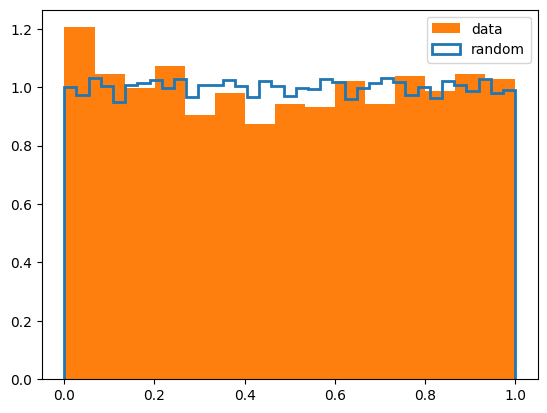

In [ ]:
plt.figure()
plt.hist(pval_data, bins="auto", color="C1", density=1, label="data")
plt.hist(pval_rand, bins="auto", density=1, label="random", histtype="step", color="C0", lw=2)

plt.legend()

plt.show()

In [ ]:
radii = np.linspace(0.1, 5, 100)

y, yerr, yrand, yranderr = prof_gen.stack_normalized_profiles(ell, b, theta200, radii, subtract_background=True,  random_profile_pool=tsz_rand, random_pool_radii=theta_rand)

NameError: name 'prof_gen' is not defined

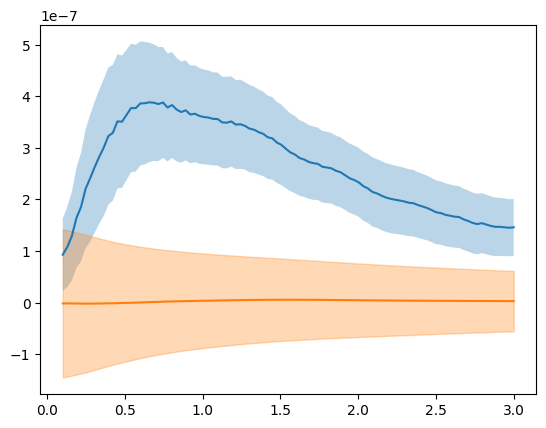

In [ ]:
plt.figure()
plt.plot(radii, y)
plt.fill_between(radii, y - yerr, y + yerr, alpha=0.3)

plt.plot(radii, yrand, color="C1")
plt.fill_between(radii, yrand - yranderr, yrand + yranderr, color="C1", alpha=0.3)

plt.show()

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_16497/107754667.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


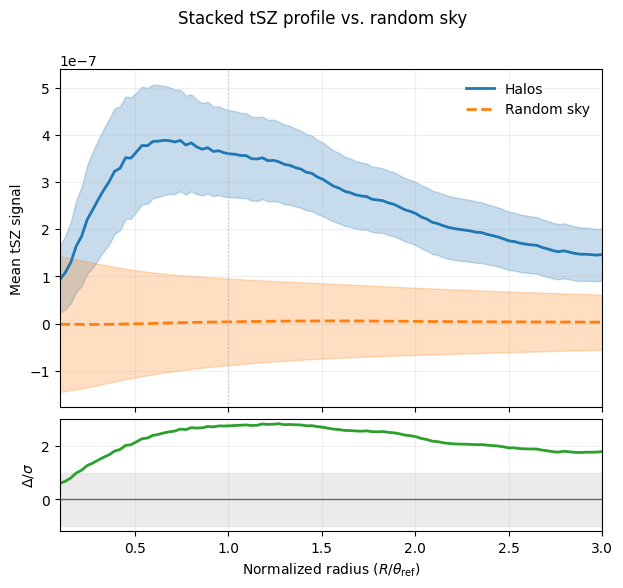

In [ ]:
# Significance of the excess over randoms
delta = y - yrand
sigma_tot = np.sqrt(yerr**2 + yranderr**2)
significance = np.divide(
    delta, sigma_tot,
    out=np.zeros_like(delta),
    where=sigma_tot > 0,
)

fig, (ax, ax_sig) = plt.subplots(
    2, 1, sharex=True, figsize=(7, 6),
    gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05},
)

# Stacked profiles
ax.plot(radii, y, lw=2, color="C0", label="Halos")
ax.fill_between(radii, y - yerr, y + yerr, color="C0", alpha=0.25)

ax.plot(radii, yrand, lw=2, ls="--", color="C1", label="Random sky")
ax.fill_between(radii, yrand - yranderr, yrand + yranderr,
                color="C1", alpha=0.25)

ax.set_ylabel("Mean tSZ signal")
ax.set_xlim(radii.min(), radii.max())
ax.grid(True, alpha=0.2)
ax.legend(frameon=False, loc="best")

# Optional reference line (e.g. theta/theta_ref = 1)
ax.axvline(1.0, color="0.7", lw=1, ls=":", alpha=0.7)

# Significance panel
ax_sig.axhline(0.0, color="0.4", lw=1)
ax_sig.axhspan(-1, 1, color="0.85", alpha=0.5, zorder=0)
ax_sig.plot(radii, significance, color="C2", lw=2)

ax_sig.set_ylabel(r"$\Delta/\sigma$")
ax_sig.set_xlabel(r"Normalized radius ($R/\theta_{\rm ref}$)")
ax_sig.grid(True, alpha=0.2)

fig.suptitle("Stacked tSZ profile vs. random sky")
plt.tight_layout()
plt.show()

In [ ]:
k = 0

radii = np.linspace(0, 3 * theta200[k], 100)

# radii = np.asanyarray([theta200[k]])

y_sub = prof_gen.get_profile(ell[k], b[k], radii, subtract_background=True)
y = prof_gen.get_profile(ell[k], b[k], radii, subtract_background=False)

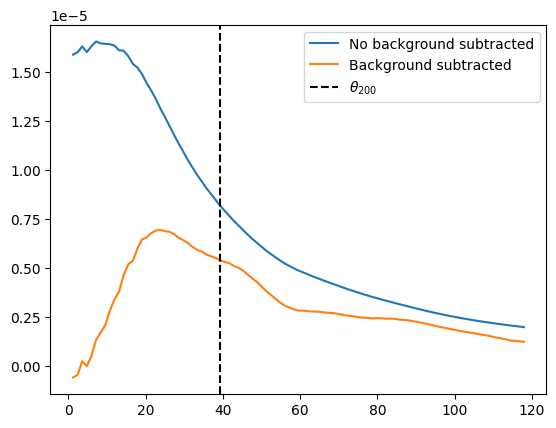

In [ ]:
plt.figure()
plt.plot(radii, y, label="No background subtracted")
plt.plot(radii, y_sub, label="Background subtracted")

plt.axvline(theta200[k], color="k", ls="--", label=r"$\theta_{200}$")

plt.legend()

plt.show()


In [ ]:
cutout_gen = cmbo.corr.Pointing2DCutout(cmb_tsz, )

In [ ]:
k = 4
size_arcmin = 5 * theta200[k]

print(pval_data[k])

cut, ext = cutout_gen.get_cutout_2d(ell_deg=ell[k], b_deg=b[k], size_arcmin=size_arcmin)

cut_norm, w_norm, extent = cutout_gen.normalize_by_theta200(cut, size_arcmin=size_arcmin, theta200_arcmin=theta200[k])

0.022017956391620297


In [ ]:
res = cmbo.corr.fit_gaussian_offset(cut, size_arcmin=size_arcmin)
res

{'success': True,
 'amp': 1.4447728557944265e-05,
 'x0_arcmin': -6.561877989295423,
 'y0_arcmin': 13.343231565076952,
 'r_arcmin': 14.86943412997501,
 'sigma_x_arcmin': 10.77551873288813,
 'sigma_y_arcmin': 12.104843414743375,
 'offset': 9.910447771399968e-07,
 'optimizer':        message: Optimization terminated successfully.
        success: True
         status: 0
            fun: 2.3298631757024362e-09
              x: [ 1.445e-05 -6.562e+00  1.334e+01  2.377e+00  2.494e+00
                   9.910e-07]
            nit: 202
           nfev: 357
  final_simplex: (array([[ 1.445e-05, -6.562e+00, ...,  2.494e+00,
                          9.910e-07],
                        [ 1.445e-05, -6.562e+00, ...,  2.494e+00,
                          9.910e-07],
                        ...,
                        [ 1.445e-05, -6.562e+00, ...,  2.494e+00,
                          9.910e-07],
                        [ 1.445e-05, -6.562e+00, ...,  2.494e+00,
                          9.910e-07]]

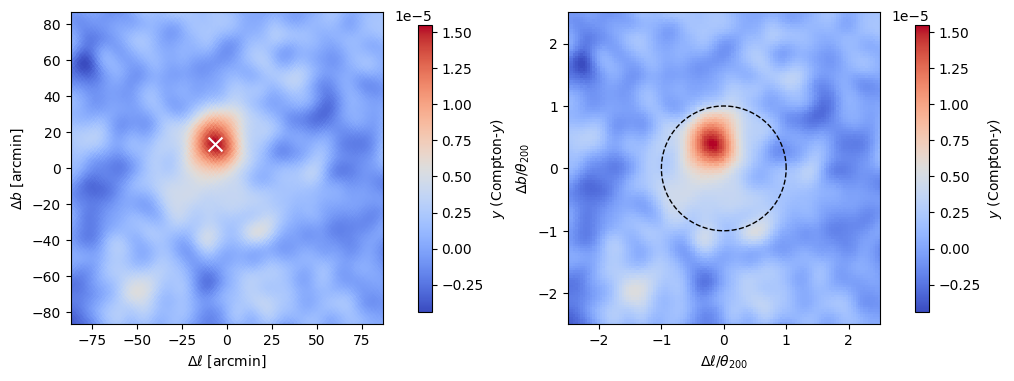

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# Left: original cutout
ax = axes[0]
im0 = ax.imshow(cut, extent=ext, origin="lower", cmap="coolwarm")

ax.scatter(res["x0_arcmin"], res["y0_arcmin"], marker="x", color="white", s=100, label="Fitted center")
ax.set_xlabel(r"$\Delta \ell$ [arcmin]")
ax.set_ylabel(r"$\Delta b$ [arcmin]")
ax.set_aspect("equal")
fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04, label=r"$y$ (Compton-$y$)")

# Right: normalized map
y_plot = np.where(w_norm > 0, cut_norm, np.nan)
ax = axes[1]
im1 = ax.imshow(
    y_plot.T,
    extent=extent,
    origin="lower",
    cmap="coolwarm",
    interpolation="nearest",
)
ax.set_aspect("equal")
ax.set_xlabel(r"$\Delta \ell / \theta_{200}$")
ax.set_ylabel(r"$\Delta b / \theta_{200}$")

# Reference circle
t = np.linspace(0, 2 * np.pi, 256)
ax.plot(np.cos(t), np.sin(t), "k--", lw=1)

fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label=r"$y$ (Compton-$y$)")

plt.show()

In [ ]:

fname_rand_pointing = "/Users/rstiskalek/Projects/cmbo/data/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00_RAND_POINTING.hdf5"

# theta_rand = np.linspace(1, 601, 101)
# tsz_rand = cmbo.corr.randpoint_enclosed_profiles(cmb_tsz, theta_rand, n_points=50_000, abs_b_min=10, n_jobs=-1, prefer="processes")
# cmbo.io.dump_to_hdf5(fname_rand_pointing, theta_rand=theta_rand, tsz_rand=tsz_rand)

theta_rand, tsz_rand = cmbo.io.read_from_hdf5(fname_rand_pointing, "theta_rand", "tsz_rand")

signal_source = cmbo.corr.pointing_enclosed_profile_per_source(cmb_tsz, ell, b, 1 * theta200)

pval = cmbo.corr.get_pointing_pvalue(signal_source, theta200, theta_rand, tsz_rand)

Measuring profiles: 100%|██████████| 210/210 [00:04<00:00, 43.30it/s] 


In [ ]:
np.argsort(pval)

array([ 13,   1,   0,   6, 139,  14,   7,   4,  30, 115, 198,  31,  62,
        26,  17, 165,  29,  25,   8,  65,  19,  10, 142,  73,  70, 133,
       119, 141,  52, 102,   5, 176, 190, 187,  27, 108,  41, 109,  78,
       203, 153, 127, 195, 164, 124, 145,  21, 169, 160,  59,  50,  60,
        91, 188, 205, 151, 146, 189, 178,  23, 140, 137,  43, 134, 191,
        54,  45,  57,  82, 117,  55, 131, 194,  90, 152, 110,  80, 206,
       162,  84, 118, 193,  85,  64,  88,  47,  94, 112,  18,  32,  74,
       208, 209, 161,  95,  63,  38,  22, 129, 120,  87,  76, 114,  35,
        33, 143, 181,   2,  79,  68,  93, 174, 168,  24,  89, 200, 172,
       149, 166, 123, 204,  98,  99, 179, 170, 186, 113, 199, 157,  71,
        67, 197,  42,  15,  53,  11,  16,  36, 180,  28, 105,  92, 177,
       128, 135, 163, 184, 207, 202,  40, 182, 100, 158,  37, 101,  12,
        51, 173,  48, 155, 171, 148, 154, 144, 150,  77, 122,  34,  83,
        81,  97, 103,   9, 121, 132, 192,  96,  20, 104, 136, 14

In [ ]:
(pval < 0.01).sum() / len(pval)

np.float64(0.0761904761904762)

312.2138247149743 30.57398572284042 39.30650982443441 8.24099697638303e-06 0.0009217380120468688 145.2730153480057 1.5487343e+15


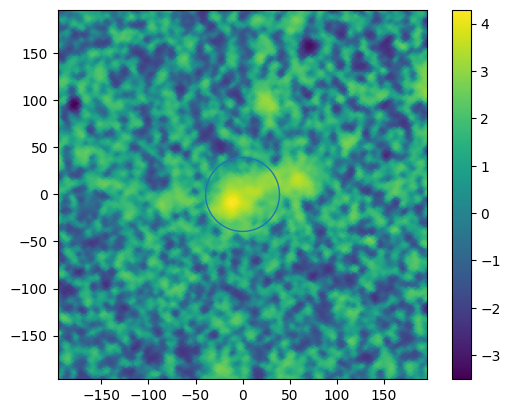

In [ ]:
k = 0

# ell_deg = 300
# b_deg = 02

# print(pval[k], theta200[k])
print(ell[k], b[k], theta200[k], signal_source[k], pval[k], r[k], mass[k])

cutout, extent, aux = cmbo.corr.pointing_cutout_2d(cmb_tsz, ell[k], b[k], 10 * theta200[k], circle_arcmin=theta200[k])
# cutout, extent, aux = cmbo.corr.pointing_cutout_2d(cmb_tsz, 0, 15, 3000, circle_arcmin=theta200[k])
# cutout, extent, aux = cmbo.corr.pointing_cutout_2d(cmb_tsz, ell[k], b[k], 25000, circle_arcmin=theta200[k])
# cutout, extent = cmbo.corr.pointing_cutout_2d(cmb_tsz, ell_deg, b_deg, 600)

plt.imshow(np.asinh(cutout / 1e-6), extent=extent, origin="lower")
plt.colorbar()
plt.plot(*aux["circle_xy"], lw=1)

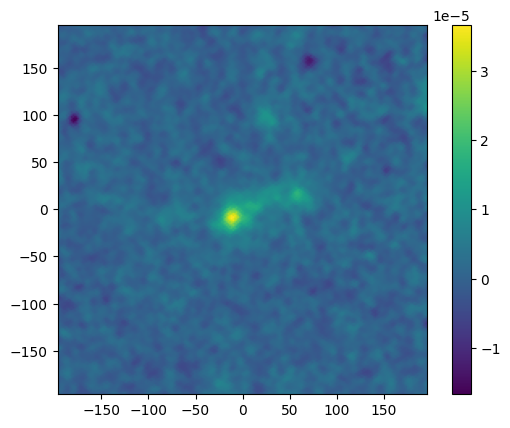

In [ ]:
plt.imshow(np.asinh(cutout / 1e-0), extent=extent, origin="lower")
plt.colorbar()

In [ ]:
theta200.mean(), theta200.std()

(np.float64(27.813398783047976), np.float64(25.4646337901173))

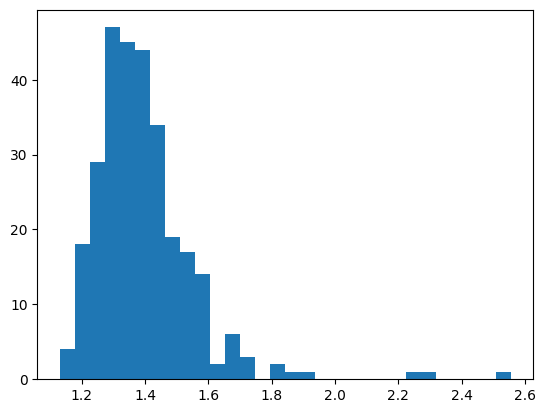

In [ ]:
m = theta200 > 0

plt.figure()
plt.hist(np.log10(theta200[m]), bins="auto")
plt.show()

In [ ]:
len(mass)

289

In [ ]:
  import numpy as np
  import matplotlib.pyplot as plt
  import healpy as hp
  from cmbo.corr.pointing import pointing_enclosed_profile

  def stack_radial_profiles_normalized(map_in, ell_deg, b_deg, theta200_arcmin,
                                       mask=None, n_radial_bins=20,
                                       radii_max_r200=3.0):
      """
      Stack radial profiles around clusters, normalized by their angular size.

      Parameters
      ----------
      map_in : array
          HEALPix map (e.g., tSZ map)
      ell_deg, b_deg : array, shape (N,)
          Cluster positions in degrees
      theta200_arcmin : array, shape (N,)
          Angular size (theta200) for each cluster in arcmin
      mask : array, optional
          Mask for the map
      n_radial_bins : int
          Number of radial bins for the profile
      radii_max_r200 : float
          Maximum radius in units of R200

      Returns
      -------
      r_normalized : array
          Radial bins in units of R200
      stacked_profile : array
          Mean profile at each radius
      profile_std : array
          Standard deviation at each radius
      """
      n_clusters = len(ell_deg)

      # Normalized radial grid (in units of R200)
      r_normalized = np.linspace(0.1, radii_max_r200, n_radial_bins)

      # Store all profiles
      all_profiles = np.full((n_clusters, n_radial_bins), np.nan)

      print(f"Computing profiles for {n_clusters} clusters...")

      for i in range(n_clusters):
          # Physical radii for this cluster (in arcmin)
          radii_arcmin = r_normalized * theta200_arcmin[i]

          # Measure enclosed profile at these radii
          profile = pointing_enclosed_profile(
              map_in, ell_deg[i], b_deg[i], radii_arcmin, mask=mask
          )

          all_profiles[i, :] = profile

          if (i + 1) % 100 == 0:
              print(f"  Processed {i+1}/{n_clusters} clusters")

      # Stack: compute mean and std (ignoring NaNs)
      stacked_profile = np.nanmean(all_profiles, axis=0)
      profile_std = np.nanstd(all_profiles, axis=0)
      profile_sem = profile_std / np.sqrt(np.sum(np.isfinite(all_profiles), axis=0))

      return r_normalized, stacked_profile, profile_std, profile_sem, all_profiles


  def plot_stacked_profile(r_normalized, stacked_profile, profile_sem,
                           profile_std=None, title="Stacked tSZ Profile"):
      """
      Plot the stacked radial profile.

      Parameters
      ----------
      r_normalized : array
          Radial bins in units of R200
      stacked_profile : array
          Mean profile
      profile_sem : array
          Standard error of the mean
      profile_std : array, optional
          Standard deviation (scatter between clusters)
      title : str
          Plot title
      """
      fig, ax = plt.subplots(figsize=(8, 6))

      # Plot the stacked profile with error bars
      ax.errorbar(r_normalized, stacked_profile, yerr=profile_sem,
                  marker='o', color='C0', label='Stacked profile (±SEM)',
                  capsize=4, linewidth=2, markersize=6)

      # Optionally show scatter as shaded region
      if profile_std is not None:
          ax.fill_between(r_normalized,
                          stacked_profile - profile_std,
                          stacked_profile + profile_std,
                          alpha=0.2, color='C0',
                          label='±1σ scatter')

      # Mark R200
      ax.axvline(1.0, color='red', linestyle='--', linewidth=1.5,
                 alpha=0.7, label='R200')
      ax.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

      ax.set_xlabel('Radius [R200]', fontsize=12)
      ax.set_ylabel('tSZ signal [μK]', fontsize=12)
      ax.set_title(title, fontsize=14)
      ax.legend(fontsize=10)
      ax.grid(True, alpha=0.3)

      plt.tight_layout()
      return fig, ax


Computing profiles for 289 clusters...
  Processed 100/289 clusters
  Processed 200/289 clusters


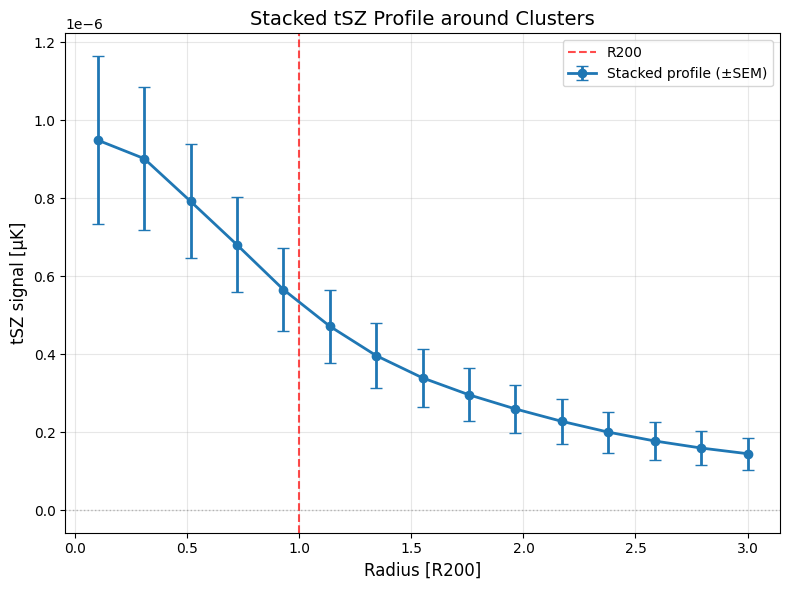


Stacking results:
  Signal at R200: 0.000 ± 0.000 μK
  Number of clusters: 289


In [ ]:
# Load your data
# tsz_map = hp.read_map("path/to/tsz_map.fits")
# halo_ell = ...  # cluster longitudes in degrees
# halo_b = ...    # cluster latitudes in degrees
# halo_theta200 = ...  # theta200 for each cluster in arcmin
# mask = ...  # optional mask

# For demonstration, let's assume you have these loaded
# tsz_map = your_map
# halo_ell = your_positions
# halo_b = your_positions
# halo_theta200 = your_angular_sizes

# Stack profiles


# ell_rand = np.random.permutation(ell)
# b_rand = np.random.permutation(b)

r_norm, profile, std, sem, all_profiles = stack_radial_profiles_normalized(
    cmb_tsz, ell, b, theta200,
    # cmb_tsz, ell_rand, b_rand, theta200,
    mask=None, n_radial_bins=15, radii_max_r200=3.0
)

# Make plot
fig, ax = plot_stacked_profile(r_norm, profile, sem, None,
                               title="Stacked tSZ Profile around Clusters")

plt.savefig("stacked_tsz_profile.png", dpi=150, bbox_inches='tight')
plt.show()
# 
# Print statistics
print(f"\nStacking results:")
print(f"  Signal at R200: {profile[np.argmin(np.abs(r_norm - 1.0))]:.3f} ± "
      f"{sem[np.argmin(np.abs(r_norm - 1.0))]:.3f} μK")
print(f"  Number of clusters: {np.sum(np.isfinite(all_profiles[:, 0]))}")


In [ ]:

fname_rand_pointing = "/Users/rstiskalek/Projects/cmbo/data/data/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00_RAND_POINTING.hdf5"

# theta_rand = np.linspace(1, 601, 101)
# tsz_rand = cmbo.corr.randpoint_enclosed_profiles(cmb_tsz, theta_rand, n_points=50_000, abs_b_min=10, n_jobs=-1, prefer="processes")
# cmbo.io.dump_to_hdf5(fname_rand_pointing, theta_rand=theta_rand, tsz_rand=tsz_rand)

theta_rand, tsz_rand = cmbo.io.read_from_hdf5(fname_rand_pointing, "theta_rand", "tsz_rand")

signal_source = cmbo.corr.pointing_enclosed_profile_per_source(cmb_tsz, ell, b, theta200)

In [ ]:
signal_source = cmbo.corr.pointing_enclosed_profile_per_source(cmb_tsz, ell, b, theta200)

Measuring profiles: 100%|██████████| 5264/5264 [01:37<00:00, 53.96it/s]


In [ ]:
ell_rand = np.random.permutation(ell)
b_rand = np.random.permutation(b)
signal_rand = cmbo.corr.pointing_enclosed_profile_per_source(cmb_tsz, ell_rand, b_rand, theta200)

Measuring profiles: 100%|██████████| 5264/5264 [01:41<00:00, 52.00it/s]


In [ ]:
pval = cmbo.corr.get_pointing_pvalue(signal_source, theta200, theta_rand, tsz_rand)

sigma = cmbo.utils.pvalue_to_sigma(pval)

pval_rand = cmbo.corr.get_pointing_pvalue(signal_rand, theta200, theta_rand, tsz_rand)
sigma_rand = cmbo.utils.pvalue_to_sigma(pval_rand)

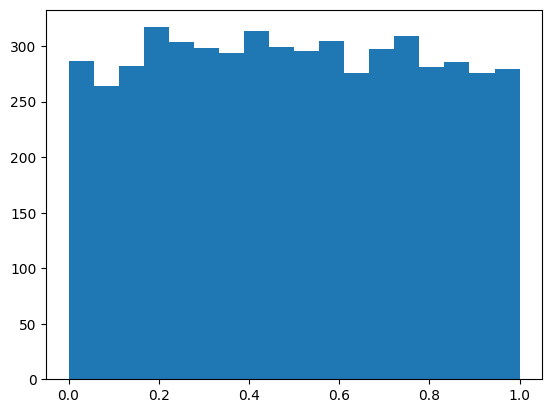

In [ ]:
plt.figure()
plt.hist(pval_rand, bins="auto")

plt.show()

In [ ]:
np.log10(np.random.uniform(0, 1, size=len(pval_rand))).min()

np.float64(-3.404686462813098)

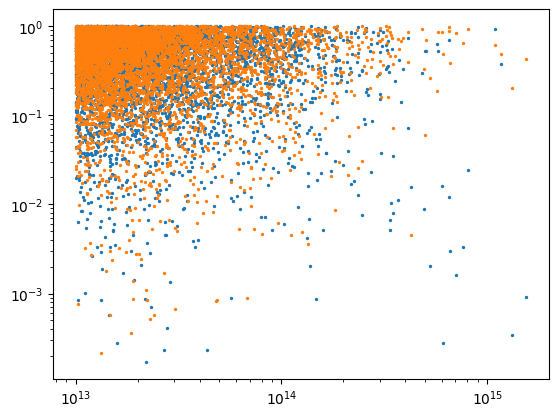

In [ ]:
plt.figure()
plt.scatter(mass, pval, s=2)
plt.scatter(mass, pval_rand, s=2)

# plt.scatter(mass, sigma, s=1)
# plt.scatter(mass, sigma_rand, s=1)

plt.xscale("log")
plt.yscale("log")

plt.show()

KstestResult(statistic=np.float64(0.75), pvalue=np.float64(0.0014969550573265746), statistic_location=np.float64(0.024501082506269922), statistic_sign=np.int8(1))
KstestResult(statistic=np.float64(0.7254989174937301), pvalue=np.float64(6.012057906485517e-07), statistic_location=np.float64(0.024501082506269922), statistic_sign=np.int8(1))


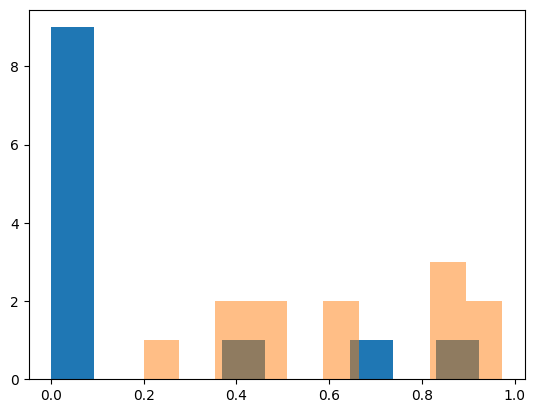

In [ ]:
from scipy.stats import ks_2samp, ks_1samp
from scipy.stats import uniform

cdf_null = uniform.cdf


m = mass > 6e14

plt.figure()
plt.hist(pval[m])
plt.hist(pval_rand[m], alpha=0.5)


print(ks_2samp(pval[m], pval_rand[m]))
print(ks_1samp(pval[m], cdf_null))


plt.show()


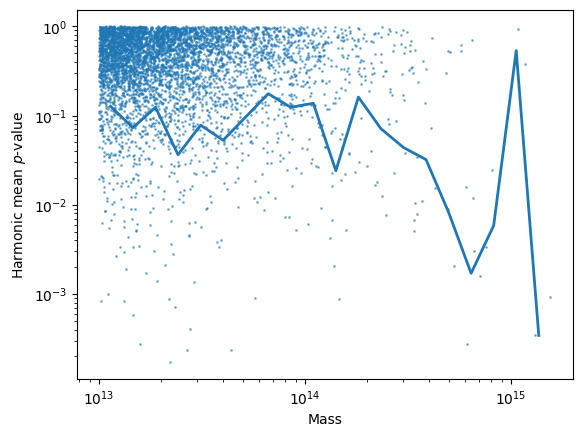

In [ ]:

def hmp_in_bins(mass, pval, nbins=5, log_bins=True, bin_edges=None,
                pmin=1e-300):
    mass = np.asarray(mass)
    pval = np.asarray(pval)

    m = np.isfinite(mass) & np.isfinite(pval) & (pval > 0)
    mass, pval = mass[m], np.clip(pval[m], pmin, 1.0)

    if bin_edges is None:
        mmin, mmax = mass.min(), mass.max()
        if log_bins:
            bin_edges = np.logspace(np.log10(mmin), np.log10(mmax), nbins + 1)
        else:
            bin_edges = np.linspace(mmin, mmax, nbins + 1)
    else:
        bin_edges = np.asarray(bin_edges)
        nbins = len(bin_edges) - 1

    idx = np.digitize(mass, bin_edges) - 1
    keep = (idx >= 0) & (idx < nbins)
    idx = idx[keep]
    p = pval[keep]

    inv_p = 1.0 / p
    sum_inv_p = np.bincount(idx, weights=inv_p, minlength=nbins)
    counts = np.bincount(idx, minlength=nbins)

    hmp = np.full(nbins, np.nan)
    ok = counts > 0
    hmp[ok] = counts[ok] / sum_inv_p[ok]

    if log_bins:
        centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    else:
        centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return centers, hmp, counts, bin_edges


# --- usage with your plot ---
centers, hmp, counts, edges = hmp_in_bins(mass, pval, nbins=20, log_bins=True)

plt.figure()
plt.scatter(mass, pval, s=1, alpha=0.5)
plt.plot(centers, hmp, lw=2)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Mass")
plt.ylabel(r"Harmonic mean $p$-value")
plt.show()

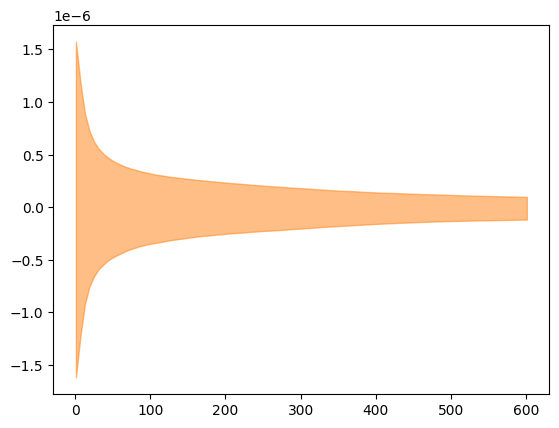

In [ ]:
ylow, yhigh = np.percentile(tsz_rand, [16, 84], axis=0)

plt.figure()

# plt.scatter(theta200, signal_source, s=1, color="C0", alpha=0.5, label="Cluster Pointings")
plt.fill_between(
    theta_rand,
    ylow,
    yhigh,
    color="C1",
    alpha=0.5,
    label="Random Pointings (16th-84th %ile)",
)

plt.show()


In [ ]:
import healpy as hp
import matplotlib.pyplot as plt

# --- Load the Planck Compton-y map (NILC or MILCA) ---
# fname = "COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits"
# # y_map = hp.read_map(fname, field=0)  # field=0 -> y map
# y_map = d["FULL"]

# scale = 0.001e-6
# y_map = np.arcsinh(y_map / scale)

# --- Virgo cluster coordinates (ICRS) ---
# ra_virgo  = 187.705   # deg
# dec_virgo = 12.391    # deg

ra_virgo = 194.95  # deg
dec_virgo = 27.98  # deg



# --- Convert to Galactic coordinates (for Healpix plotting) ---
from astropy.coordinates import SkyCoord
import astropy.units as u

coord = SkyCoord(ra=ra_virgo*u.deg, dec=dec_virgo*u.deg, frame='icrs')
l_virgo = coord.galactic.l.deg
b_virgo = coord.galactic.b.deg
print(f"Virgo in Galactic coords: l={l_virgo:.2f}, b={b_virgo:.2f}")

# # --- Plot a zoomed view ---
# hp.gnomview(
#     y_map,
#     rot=(l_virgo, b_virgo),   # center of the view (Galactic coords)
#     xsize=800,                # pixel width of the patch
#     # reso=0.1,                 # arcmin per pixel
#     reso=1,
#     title="Virgo Cluster Region (Planck y-map)",
#     unit="Compton-y",
#     # min=-5, max=5,            # adjust for contrast
#     cmap="viridis"
# )

# # --- Add a circular overlay (e.g., 3° radius) ---
# # hp.projcircle(l_virgo, b_virgo, radius=np.radians(3.0), lonlat=True,
#             #   color="red", lw=1.5)
# plt.show()

Virgo in Galactic coords: l=58.09, b=87.96


In [ ]:
x = np.copy(d["FULL"])

x0 = np.copy(x)
mask0 = np.copy(d["MASK"])

# x -= np.copy(d["LAST"])

scale = 0.005e-6
x = np.arcsinh(x / scale)

mask = np.copy(d["MASK"])

mask = np.where(mask == 0)[0]

# x /= np.mean(x)
# x -= np.min(x)


x[mask] = np.nan

In [ ]:
np.isnan(mask).sum()

np.int64(0)

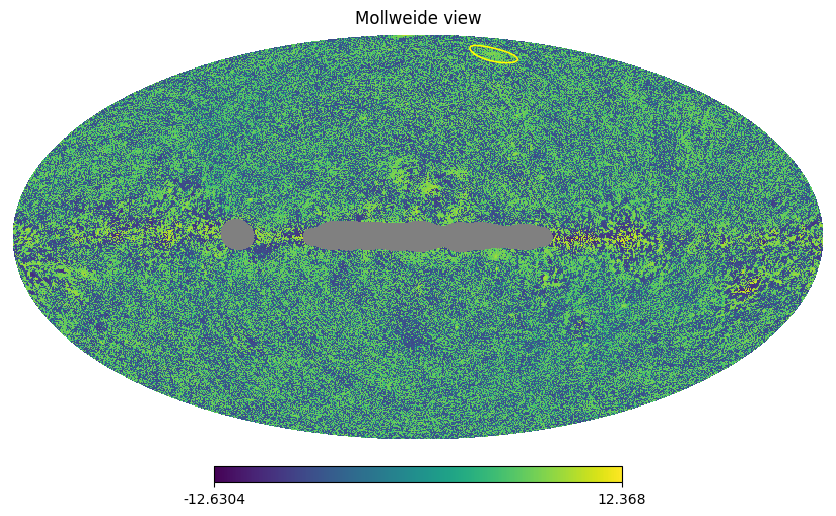

In [ ]:
hp.mollview(x, )
# Virgo coordinates (Galactic)
virgo_l, virgo_b = 283.8, 74.5

# Compute circle coordinates
phi = np.linspace(0, 2 * np.pi, 361)
radius = 5
# great-circle approximation using small-angle formula
l_circ = virgo_l + radius * np.cos(phi) / np.cos(np.radians(virgo_b))
b_circ = virgo_b + radius * np.sin(phi)

# Draw the circle and the Virgo marker
hp.projplot(l_circ, b_circ, lonlat=True, color="yellow", linewidth=1.2)
# hp.projplot(virgo_l, virgo_b, lonlat=True, marker='*', color='yellow', markersize=8)
# hp.projtext(virgo_l + 5, virgo_b, "Virgo", lonlat=True, color='yellow')


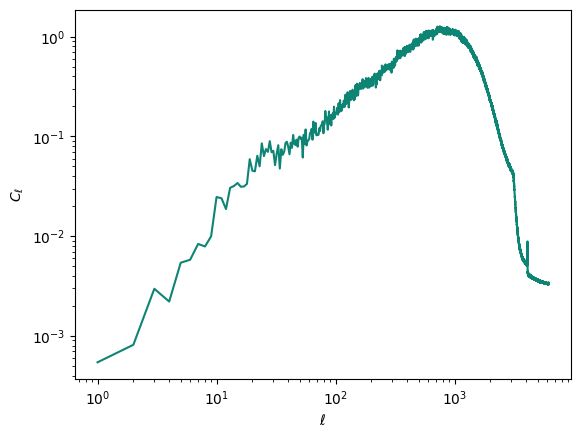

In [ ]:
# --- Compute the power spectrum ---
lmax = 3 * hp.get_nside(x) - 1
cl = hp.anafast(x0, lmax=lmax, gal_cut=20)

# --- Corresponding ell values ---
ell = np.arange(len(cl))

# --- Print and/or plot ---
import matplotlib.pyplot as plt
plt.loglog(ell[1:], cl[1:] * ell[1:] * (1 + ell[1:]) / (2 * np.pi) * 1e12, color=cmr.rainforest(0.5))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
# plt.title("WebSky Compton-y Power Spectrum")
plt.show()

In [ ]:
fname = "/Users/rstiskalek/Downloads/tsz_new.fits"

from astropy.io import fits
d = fits.open(fname)[1].data


x = d['T'][:, 300] #* 1e5


# # --- Smooth with Planck y effective beam (~10 arcmin FWHM) ---
# fwhm = np.radians(10.0 / 60.0)   # 10'
# y_smooth = hp.smoothing(x, fwhm=fwhm, verbose=False)

# # --- (Optional) downgrade to Planck y resolution ---
# x = hp.ud_grade(y_smooth, nside_out=2048,
#                             order_in='RING', order_out='RING')

# x -= x.mean()

x = np.log10(x)

# x = np.random.normal(size=x.size)
# x *= 1e6
# scale = 0.005e-6
# x = np.arcsinh(x / scale)

# x = hp.ud_grade(x, nside_out=32, order_in='RING', order_out='RING')

# fwhm = np.radians(10/60)  # 10 arcmin
# x = hp.smoothing(x, fwhm=fwhm, verbose=False)

# (Optional) Down-grade for display speed
# x = hp.ud_grade(x, nside_out=2048, order_in='RING', order_out='RING')

# Asinh stretch
# scale = np.abs(x).mean()
# x = np.arcsinh(x/ scale)


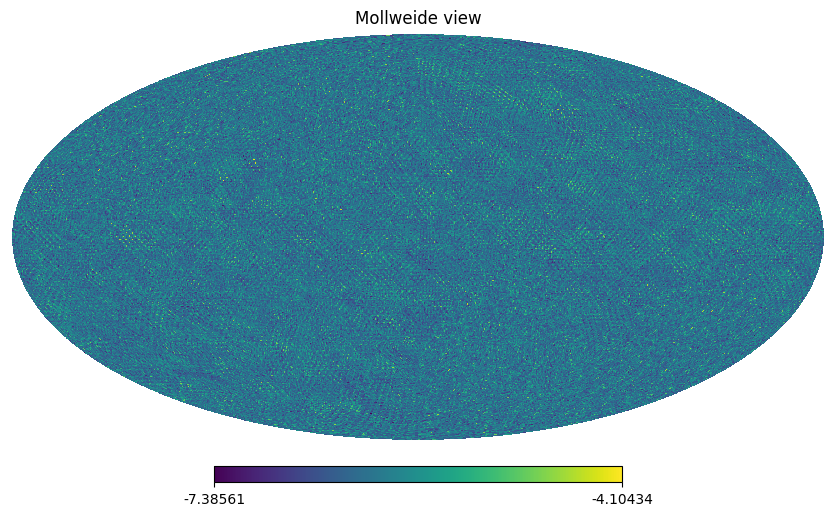

In [ ]:
hp.mollview(x, xsize=4000, nest=True, )
# plt.savefig("/Users/rstiskalek/Downloads/tsz_map.png", dpi=300)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_74010/2197780426.py:17: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axins.imshow(proj[y0:y1, x0:x1], origin='lower', cmap='magma')
/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_74010/2197780426.py:17: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axins.imshow(proj[y0:y1, x0:x1], origin='lower', cmap='magma')
/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_74010/2197780426.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


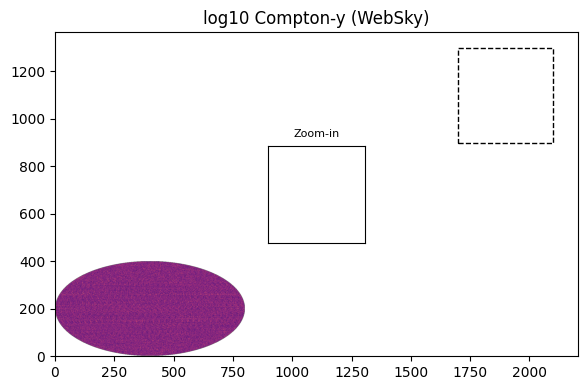

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Get Mollweide projection as 2D image array ---
proj = hp.mollview(x, return_projected_map=True, cmap='magma',
                   norm='log', min=1e-7, max=1e-4, cbar=False)
plt.close()  # avoid showing automatically

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(proj, origin='lower', cmap='magma')
ax.set_title("log10 Compton-y (WebSky)")

# --- Add a zoomed inset ---
axins = inset_axes(ax, width="30%", height="30%", loc='center')
# Pick pixel coordinates manually or by slicing
x0, x1 = 1700, 2100
y0, y1 = 900, 1300
axins.imshow(proj[y0:y1, x0:x1], origin='lower', cmap='magma')
axins.set_xticks([]); axins.set_yticks([])
axins.set_title("Zoom-in", fontsize=8)

# --- Mark the inset region on main plot ---
ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k--', lw=1)

plt.tight_layout()
plt.show()

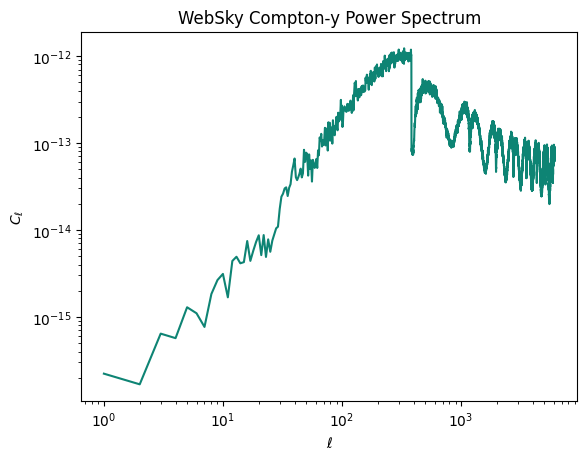

In [ ]:
# --- Compute the power spectrum ---
lmax = 3 * hp.get_nside(x) - 1
cl = hp.anafast(x, lmax=lmax)

# --- Corresponding ell values ---
ell = np.arange(len(cl))

# --- Print and/or plot ---
import matplotlib.pyplot as plt
plt.loglog(ell[1:], cl[1:] * ell[1:] * (1 + ell[1:]) / (2 * np.pi), color=cmr.rainforest(0.5))
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("WebSky Compton-y Power Spectrum")
plt.show()

In [ ]:
cl

array([5.24527724e-23, 7.00245347e-16, 1.76044717e-16, 3.37088495e-16,
       1.79513940e-16, 2.70918663e-16, 1.65059011e-16, 8.62950220e-17,
       1.60587407e-16, 1.85589114e-16, 1.78616144e-16, 8.01808538e-17,
       1.77634402e-16, 1.70317637e-16, 1.24229243e-16, 1.11930030e-16,
       1.72600960e-16, 9.08135861e-17, 1.06624912e-16, 1.21130982e-16,
       1.30550830e-16, 7.01416056e-17, 1.08880571e-16, 5.60516846e-17,
       8.21515625e-17, 5.45488595e-17, 6.79934148e-17, 7.43261037e-17,
       8.12959135e-17, 7.92709705e-17, 1.18696108e-16, 1.54008953e-16,
       1.56969899e-16, 1.69579852e-16, 1.64630646e-16, 1.23637281e-16,
       1.45447344e-16, 1.51772474e-16, 2.00440539e-16, 2.25249511e-16,
       2.56897559e-16, 1.49239952e-16, 1.31936300e-16, 1.36326218e-16,
       1.43213712e-16, 1.56208313e-16, 1.18739516e-16, 1.26475487e-16,
       2.26962791e-16, 1.58264867e-16, 1.94232014e-16, 1.81243748e-16,
       9.81007810e-17, 1.65611937e-16, 1.08576337e-16, 1.31849343e-16,
      

In [ ]:
def load_C15():
    fname = "/Users/rstiskalek/Projects/CANDEL/data/fields/carrick2015_twompp_density.npy"
    rho = 1 + np.load(fname)
    boxsize = 400
    observer = np.array([200, 200, 200])

    return rho, boxsize, observer


def load_CB():
    fname = "/Users/rstiskalek/Projects/cmbo/data/data/snapshot_099_full.hdf5"
    reader = cmbo.io.Gadget4Reader(fname, flip_xz=True)
    pos = reader.load_positions(["PartType1", "PartType5"], concat=True)

    boxsize = reader.header["BoxSize"]
    center = [boxsize / 2] * 3
    print(center)
    # pos = cmbo.utils.cartesian_icrs_to_galactic(pos, center=center, chunk=int(1e7))

    # return pos, boxsize, center

In [ ]:
# rho_C15, boxsize_C15, observer_C15 = load_C15()
load_CB()

[338.3, 338.3, 338.3]


In [ ]:
338.3 * 2

676.6

In [ ]:
nside = 64
Rmax = 150

map_C15 = cmbo.projection.grid_ngp_projection(nside, rho_C15, boxsize_C15, observer_C15, Rmax=Rmax, Rmin=0, dr=0.25, r_power=2)
# map_C15 = np.random.normal(0.0, 1, hp.nside2npix(nside))
# map_CB = cmbo.projection.particle_ngp_projection(nside, pos_CB, center_CB, Rmax=Rmax)
# map_CB = cmbo.projection.grid_ngp_projection(nside, rho_C15, boxsize_C15, observer_C15, Rmax=Rmax + 5, Rmin=+5, dr=0.25, r_power=2)

# map_CB = np.random.normal(0.0, 1, hp.nside2npix(nside))

def remove_monopole_dipole(m, mask=None, fitval=False):
    """
    Remove monopole and dipole from a HEALPix map using healpy.
    The fit is done only on unmasked pixels.
    """
    m = np.asarray(m, float)
    if mask is None:
        mask = np.isfinite(m) & (m != hp.UNSEEN)
    else:
        mask = (mask > 0) & np.isfinite(m) & (m != hp.UNSEEN)

    # m_clean, monopole, dipole = hp.remove_dipole(m, )
    m_clean = hp.remove_dipole(m)
    # if fitval:
        # return m_clean, monopole, dipole
    # else:
    return m_clean
    
map_C15 = remove_monopole_dipole(map_C15)
# map_CB = remove_monopole_dipole(map_CB)

2025-10-27 15:59:39 building the 3D grid interpolator...
2025-10-27 15:59:39 going to evaluate 601 radial samples from 0 to 150...


Projecting grid: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


In [ ]:
def phase_randomize(map_in, lmax=None, seed=None):
    """
    Return a phase-randomised version of a HEALPix map, preserving its Cl.
    """
    nside = hp.get_nside(map_in)
    if lmax is None:
        lmax = 3 * nside - 1

    # Compute spherical-harmonic coefficients
    alm = hp.map2alm(map_in, lmax=lmax, iter=0)
    rng = np.random.default_rng(seed)

    # Draw random uniform phases
    random_phases = rng.uniform(0, 2*np.pi, size=alm.size)

    # Preserve amplitude, randomise phase
    alm_rand = np.abs(alm) * np.exp(1j * random_phases)

    # Transform back to real-space map
    map_rand = hp.alm2map(alm_rand, nside=nside, lmax=lmax, verbose=False)

    return map_rand

In [ ]:
xnew = phase_randomize(map_C15, seed=42)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_74010/753290033.py:20: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  map_rand = hp.alm2map(alm_rand, nside=nside, lmax=lmax, verbose=False)


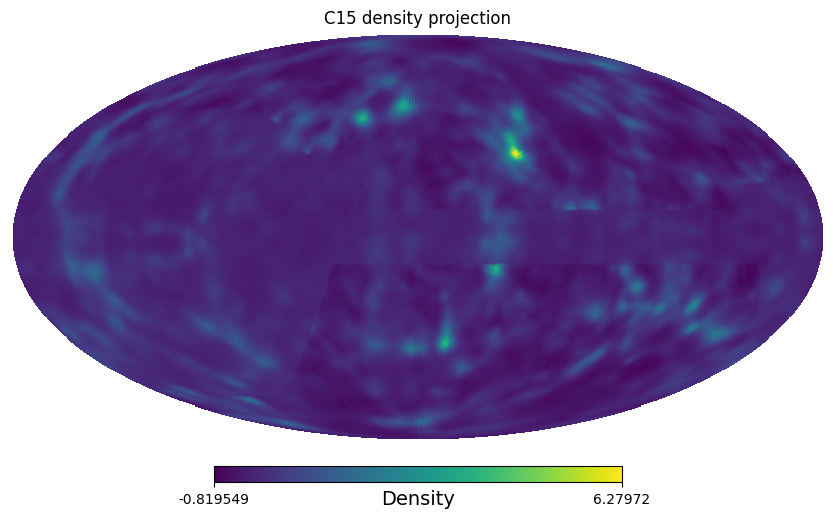

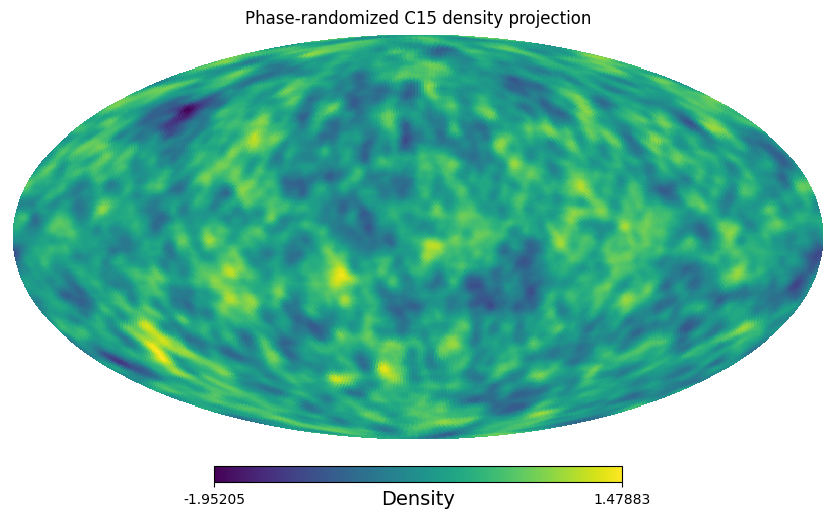

In [ ]:
hp.mollview(map_C15, title="C15 density projection", unit="Density", cmap="viridis")
hp.mollview(xnew, title="Phase-randomized C15 density projection", unit="Density", cmap="viridis")

In [ ]:
def noisy_random_map_from_input(map_in, noise_sigma=None, noise_cl=None,
                                lmax=None, seed=0, smooth_fwhm=None):
    nside = hp.get_nside(map_in)
    if lmax is None:
        lmax = 3 * nside - 1

    rng = np.random.default_rng(seed)

    # 1. Get signal alms from input map
    alm_in = hp.map2alm(map_in, lmax=lmax, iter=3)

    # Optional smoothing (e.g., match beam)
    if smooth_fwhm is not None:
        bl = hp.gauss_beam(smooth_fwhm, lmax=lmax)
        alm_in = hp.almxfl(alm_in, bl)

    # 2. Generate signal realization (new phases, same Cl)
    cl_signal = hp.alm2cl(alm_in)
    alm_rand = hp.synalm(cl_signal, lmax=lmax, new=True)

    # 3. Add harmonic-space noise if provided
    if noise_cl is not None:
        alm_noise = hp.synalm(noise_cl, lmax=lmax, new=True)
        alm_rand += alm_noise

    # 4. Back to map space
    m_sim = hp.alm2map(alm_rand, nside=nside, lmax=lmax, verbose=False)

    m_sim -= np.min(m_sim) #@+ 10 * noise_sigma  # preserve approximate offset

    # 5. Add pixel-space white noise if requested
    if noise_sigma is not None:
        m_sim += rng.normal(0.0, noise_sigma, hp.nside2npix(nside))

    return m_sim, alm_in

In [ ]:
map_test.min()

np.float64(-0.10370127822495936)

In [ ]:
map_test, __ = noisy_random_map_from_input(map_C15, noise_sigma=0.01)



/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_65881/1206627486.py:27: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  m_sim = hp.alm2map(alm_rand, nside=nside, lmax=lmax, verbose=False)


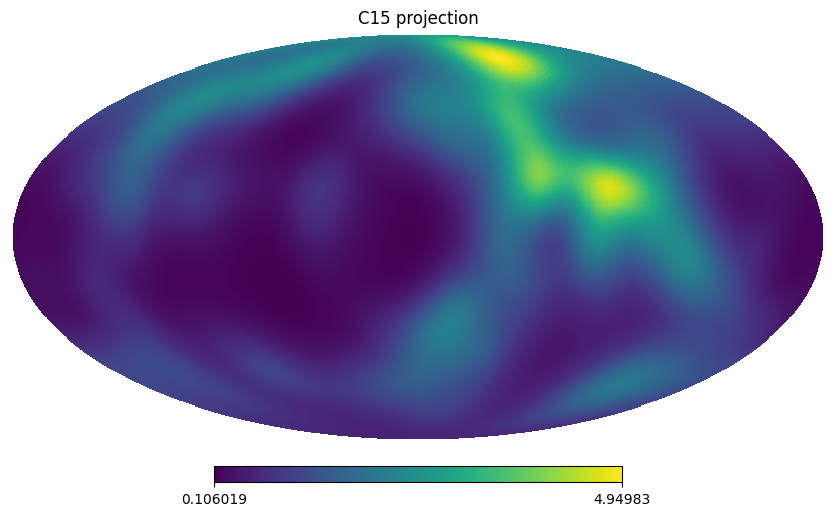

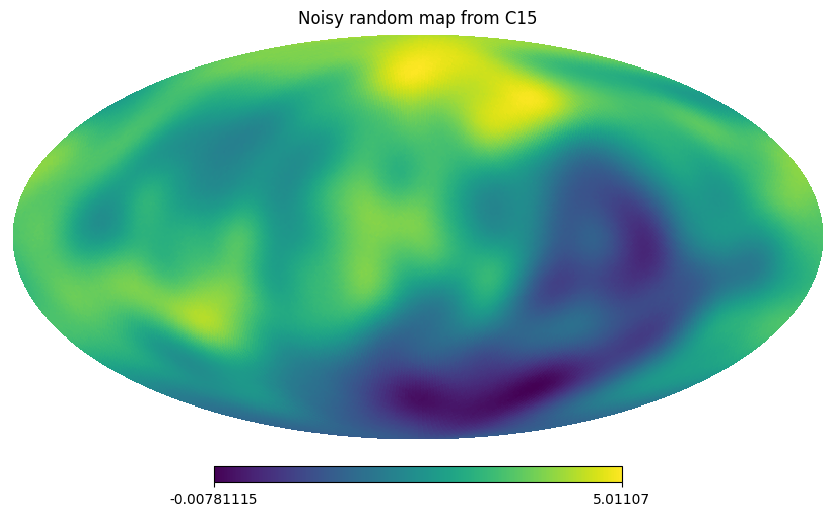

In [ ]:
hp.mollview(map_C15, title="C15 projection", )

hp.mollview(map_test, title="Noisy random map from C15", )

In [ ]:
def random_cross_cl_distribution(nside=256, nreal=500, lmax=None, seed=0):
    """
    Generate pairs of Gaussian random HEALPix maps and compute their cross-power spectra.

    Parameters
    ----------
    nside : int
        HEALPix resolution parameter.
    nreal : int
        Number of random realizations.
    lmax : int, optional
        Maximum multipole. Default is 3 * nside - 1.
    seed : int
        Random seed.

    Returns
    -------
    ell : ndarray, shape (lmax+1,)
        Multipole indices.
    cls : ndarray, shape (nreal, lmax+1)
        Cross-spectra for each realization.
    cl_mean : ndarray
        Mean cross-power ⟨Cℓ⟩ across realizations.
    cl_std : ndarray
        Standard deviation of Cℓ across realizations.
    """
    rng = np.random.default_rng(seed)
    if lmax is None:
        lmax = 3 * nside - 1
    npix = hp.nside2npix(nside)

    ell = np.arange(lmax + 1)
    cls = np.empty((nreal, lmax + 1), dtype=float)

    from tqdm import trange
    for i in trange(nreal, desc="Computing random cross-spectra"):
        # Generate two independent Gaussian random maps
        map_A = rng.normal(0.0, 1.0, npix)
        map_B = rng.normal(0.0, 1.0, npix)

        # Compute their cross-spectrum
        cls[i] = hp.anafast(map_A, map_B, lmax=lmax)

    # Mean and scatter across realizations
    cl_mean = np.mean(cls, axis=0)
    cl_std = np.std(cls, axis=0, ddof=1)
    return ell, cls, cl_mean, cl_std

In [ ]:
# map_CB = cmbo.projection.gaussian_smooth_map(map_CB, fwhm_arcmin=60)

In [ ]:
import numpy as np
import healpy as hp

def _rand_euler(rng):
    a = rng.uniform(0.0, 2.0 * np.pi)
    b = np.arccos(rng.uniform(-1.0, 1.0))
    g = rng.uniform(0.0, 2.0 * np.pi)
    return a, b, g

def _rotate_map_and_mask(m, mask, alpha, beta, gamma):
    rot = hp.Rotator(rot=[alpha, beta, gamma], eulertype='ZYZ')
    m_rot = rot.rotate_map_pixel(m)
    if mask is None:
        return m_rot, None
    # rotate mask in float space then threshold back to boolean
    mask_rot = rot.rotate_map_pixel(mask.astype(float)) > 0.5
    return m_rot, mask_rot

def cross_random_rotations(map1, map2, mask1=None, mask2=None, *,
                           nreal=500, lmax=None, seed=0,
                           deconvolve_pixwin=True, shot1=0.0, shot2=0.0):
    """
    Null-test by randomly rotating `map2` (and `mask2`) relative to `map1`.
    Returns an array of cross-spectra (nreal, lmax+1) and per-ell mean/std.
    """
    map1 = np.asarray(map1, dtype=float)
    map2 = np.asarray(map2, dtype=float)

    nside = hp.get_nside(map1)
    if hp.get_nside(map2) != nside:
        raise ValueError("Maps must share nside.")
    if lmax is None:
        lmax = 3 * nside - 1
    ell = np.arange(lmax + 1)

    if mask1 is None:
        mask1 = np.ones_like(map1, dtype=bool)
    if mask2 is None:
        mask2 = np.ones_like(map2, dtype=bool)

    rng = np.random.default_rng(seed)
    cls = np.empty((nreal, lmax + 1), dtype=float)

    # precompute pixel window if needed
    pw = hp.pixwin(nside, lmax=lmax) if deconvolve_pixwin else None
    from tqdm import trange

    for i in trange(nreal):
        a, b, g = _rand_euler(rng)
        m2r, mask2r = _rotate_map_and_mask(map2, mask2, a, b, g)
        mask = (mask1.astype(bool) &
                (mask2r if mask2r is not None else True) &
                np.isfinite(map1) & np.isfinite(m2r) &
                (map1 != hp.UNSEEN) & (m2r != hp.UNSEEN))

        mm1 = hp.ma(map1); mm1.mask = ~mask
        mm2 = hp.ma(m2r);  mm2.mask = ~mask

        cl12 = cmbo.corr.cross_cl_healpix(mm1, mm2, )[1]

        # cl12 = hp.anafast(mm1, mm2, lmax=lmax, iter=3)
        # if deconvolve_pixwin:
        #     cl12 = cl12 / (pw**2)

        # optional: consistent analytic error needs autos; skip here—this is a null draw
        cls[i] = cl12

    cl_mean = np.mean(cls, axis=0)
    cl_std  = np.std(cls, axis=0, ddof=1)
    return ell, cls, cl_mean, cl_std

In [ ]:
ell, Cl, e_Cl = cmbo.corr.cross_cl_healpix(map_C15, map_CB,)


# ell_rand, Cl_rand, __, __ =  random_cross_cl_distribution(nside=nside, nreal=5000, seed=42)

# Cl_rand_mean = np.mean(Cl_rand, axis=0)
# Cl_rand_std  = np.std(Cl_rand, axis=0)

ell_rand, Cl_rand, Cl_rand_mean, Cl_rand_std = cross_random_rotations(
    map_C15, map_CB, nreal=1000, seed=42)

100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


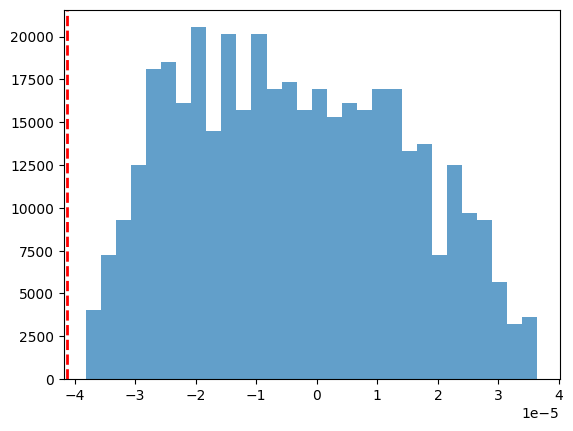

In [ ]:
ell_i = 10

plt.figure()

plt.hist(Cl_rand[:, ell_i], bins=30, density=True, alpha=0.7)
plt.axvline(Cl[ell_i], color='red', linestyle='dashed', linewidth=2, label='Observed Cl')

plt.show()


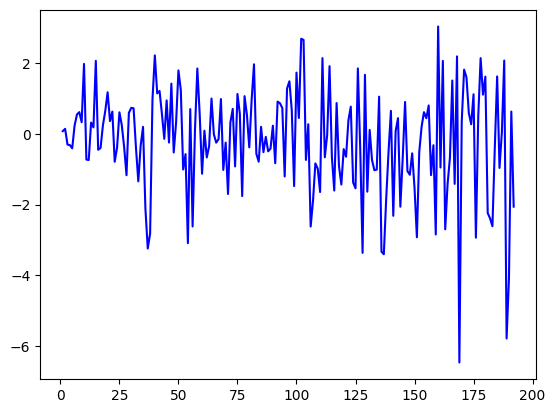

In [ ]:
plt.plot(1 + ell, (Cl - Cl_rand_mean) / Cl_rand_std, label='Observed - Mean Random', color='blue')
# plt.yscale("log")


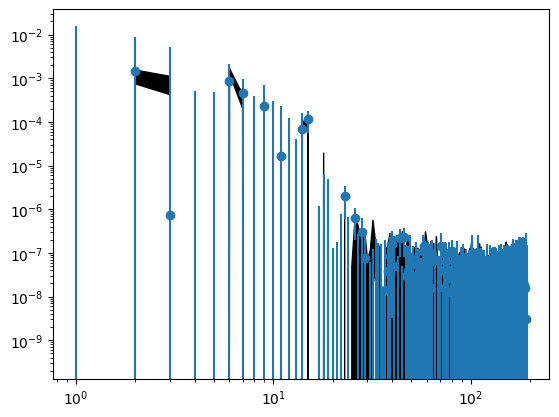

In [ ]:
plt.figure()
plt.errorbar(1 + ell, Cl, yerr=e_Cl, fmt='o', label='Cross-spectrum')


plt.fill_between(1 + ell_rand, Cl_rand_mean - Cl_rand_std, Cl_rand_mean + Cl_rand_std, label='Random rotations ±1σ', color="k")


plt.xscale("log")
plt.yscale("log")


plt.show()

In [ ]:
# map_CB_smooth = cmbo.projection.gaussian_smooth_map(map_CB, None)

In [ ]:
# map_C15 /= np.mean(map_C15)
# map_CB /= np.mean(map_CB)

# map_C15 -= 1
# map_CB -= 1

In [ ]:
ell, Cl, e_Cl = cmbo.corr.cross_cl_healpix(map_C15, map_CB,)

f_sky = 1.000


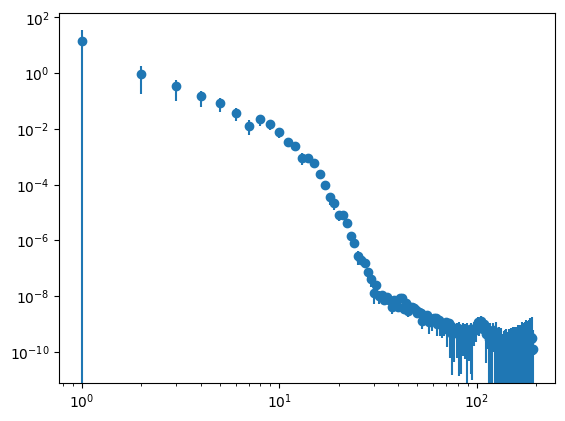

In [ ]:
plt.figure()
# plt.plot(1 + ell, Cl)
plt.errorbar(1 + ell, Cl, yerr=e_Cl, fmt='o')

plt.yscale("log")
plt.xscale("log")

plt.show()

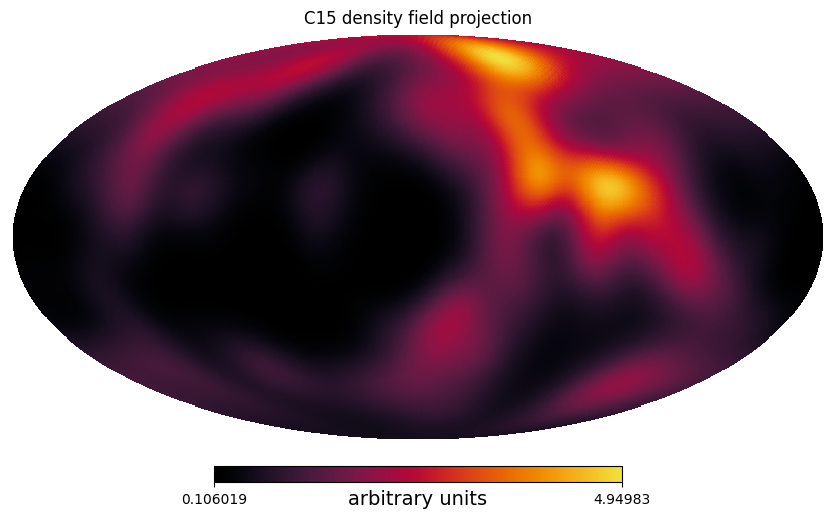

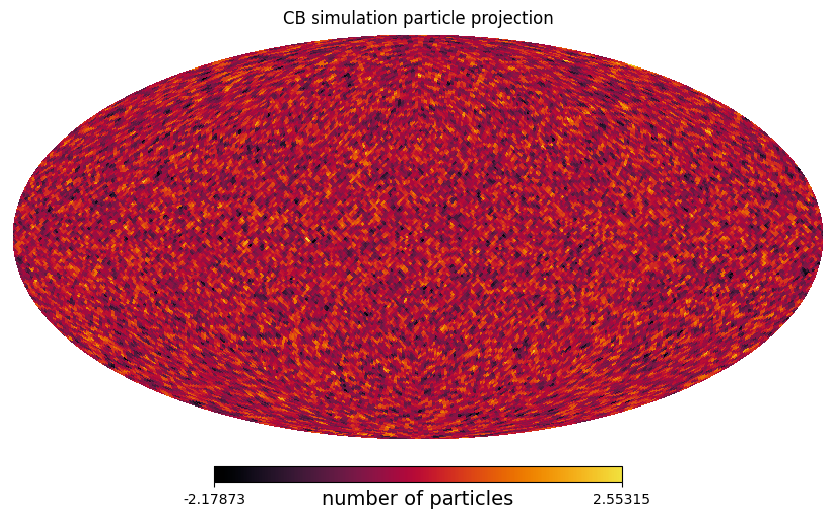

In [ ]:
hp.mollview(map_C15, title="C15 density field projection", unit="arbitrary units", cmap=cmr.ember)


hp.mollview(map_CB, title="CB simulation particle projection", unit="number of particles", cmap=cmr.ember)

Virgo (Galactic): l=283.775°, b=74.491°


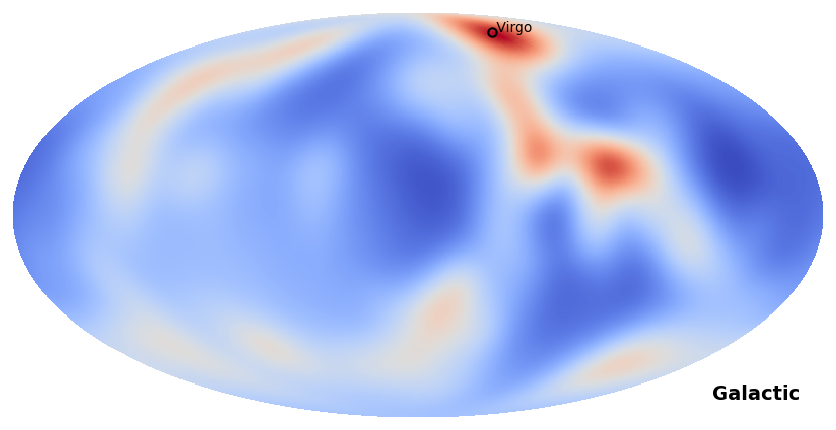

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

# Example: use M87 (Virgo A) as Virgo’s center
virgo_icrs = SkyCoord(ra=187.705*u.deg, dec=12.391*u.deg, frame="icrs")
# virgo_icrs = SkyCoord(ra=194.95 * u.deg, dec=27.98 * u.deg, frame="icrs")  # This is COMA
virgo_gal = virgo_icrs.galactic
l_virgo = virgo_gal.l.deg
b_virgo = virgo_gal.b.deg
print(f"Virgo (Galactic): l={l_virgo:.3f}°, b={b_virgo:.3f}°")

# Plot your (Galactic) map
hp.mollview(x, cmap="coolwarm", coord="G",
            title="", cbar=False, remove_mono=True, remove_dip=True)

# Overlay Virgo marker + label. lonlat=True expects (lon=l, lat=b) in degrees.
hp.projplot(l_virgo, b_virgo, lonlat=True, marker="o", ms=6, mfc="none", mec="k", mew=1.5)
hp.projtext(l_virgo, b_virgo, " Virgo", lonlat=True, size=10)

plt.show()

In [ ]:
fname = "/Users/rstiskalek/Projects/cmbo/data/data/snapshot_099_full.hdf5"
reader = cmbo.io.Gadget4Reader(fname, flip_xz=True)
pos = reader.load_positions(["PartType1", "PartType5"], concat=True)

# pos[:, [0, 2]] = pos[:, [2, 0],]  # Swap two particles to see if they move in the map

boxsize = reader.header["BoxSize"]
print(f"Boxsize = {boxsize}")
center = [boxsize / 2] * 3


<KeysViewHDF5 ['Config', 'Header', 'Parameters', 'PartType1', 'PartType5']>
<KeysViewHDF5 ['BoxSize', 'Git_commit', 'Git_date', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'Redshift', 'Time']>
<KeysViewHDF5 ['ALLOW_HDF5_COMPRESSION', 'FOF', 'FOF_PRIMARY_LINK_TYPES', 'FOF_SECONDARY_LINK_TYPES', 'GADGET2_HEADER', 'HRPMGRID', 'INDIVIDUAL_GRAVITY_SOFTENING', 'MERGERTREE', 'NSOFTCLASSES', 'NTYPES', 'NUMBER_OF_MPI_LISTENERS_PER_NODE', 'OUTPUT_VELOCITIES_IN_HALF_PRECISION', 'PERIODIC', 'PMGRID', 'PM_ZOOM_OPTIMIZED', 'RANDOMIZE_DOMAINCENTER', 'RCUT', 'REDUCE_FLUSH', 'SELFGRAVITY', 'SUBFIND', 'SUBFIND_HBT', 'SUBFIND_ORPHAN_TREATMENT']>
<KeysViewHDF5 ['BoxSize', 'Git_commit', 'Git_date', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'Redshift', 'Time']>
Boxsize = 676.6


In [ ]:
pos = cmbo.utils.cartesian_icrs_to_galactic(pos, center=center, chunk=int(1e7))

Rotating coordinates: 100%|██████████| 46/46 [00:10<00:00,  4.24it/s]


In [ ]:
nside = 256

ngpmap = cmbo.projection.particle_ngp_projection(nside, pos, center, Rmax=30, Rmin=0)

Projecting particles: 100%|██████████| 455/455 [00:04<00:00, 91.45it/s]


Virgo (Galactic): l=283.775°, b=74.491°


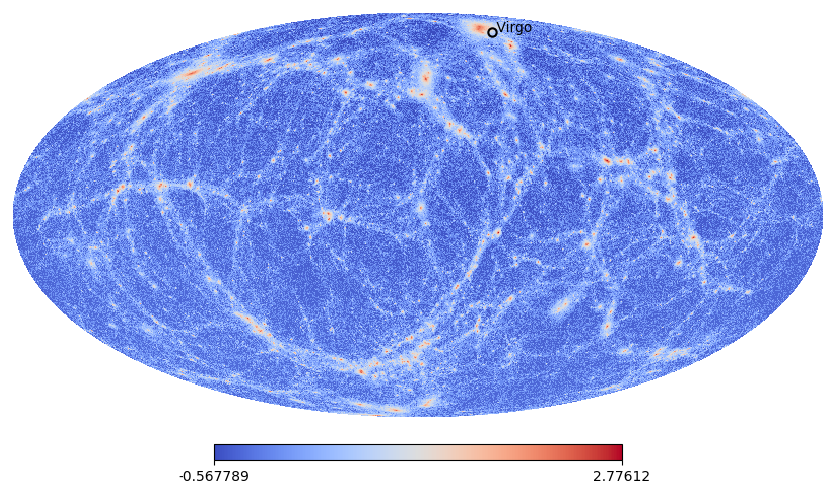

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

# Example: use M87 (Virgo A) as Virgo’s center
virgo_icrs = SkyCoord(ra=187.705*u.deg, dec=12.391*u.deg, frame="icrs")
# virgo_icrs = SkyCoord(ra=194.95 * u.deg, dec=27.98 * u.deg, frame="icrs")  # This is COMA

# l_virgo = virgo_icrs.icrs.ra.deg
# b_virgo = virgo_icrs.icrs.dec.deg

virgo_gal = virgo_icrs.galactic
l_virgo = virgo_gal.l.deg 
b_virgo = virgo_gal.b.deg
print(f"Virgo (Galactic): l={l_virgo:.3f}°, b={b_virgo:.3f}°")

# Plot your (Galactic) map
hp.mollview(np.log10(ngpmap + 1), cmap="coolwarm", 
            title="", cbar=True, remove_mono=True, remove_dip=True)

# Overlay Virgo marker + label. lonlat=True expects (lon=l, lat=b) in degrees.
hp.projplot(l_virgo, b_virgo, lonlat=True, marker="o", ms=6, mfc="none", mec="k", mew=1.5)
hp.projtext(l_virgo, b_virgo, " Virgo", lonlat=True, size=10)

plt.show()

In [ ]:
smooth_map = cmbo.projection.gaussian_smooth_map(ngpmap, 40, nside_out=None)

In [ ]:
smooth_map.max()

np.float64(796.2151753114018)

In [ ]:
smooth_map.max()

np.float64(796.2151753114018)

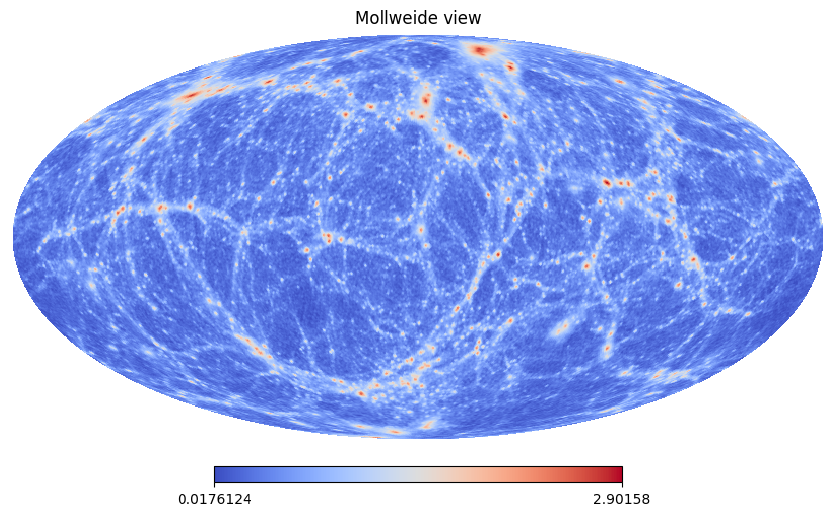

In [ ]:
hp.mollview(np.log10(1 + smooth_map), cmap="coolwarm", )

In [ ]:
view = cmbo.projection.gaussian_smooth_map(ngpmap, 30, nside_out=None)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_36664/179294396.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


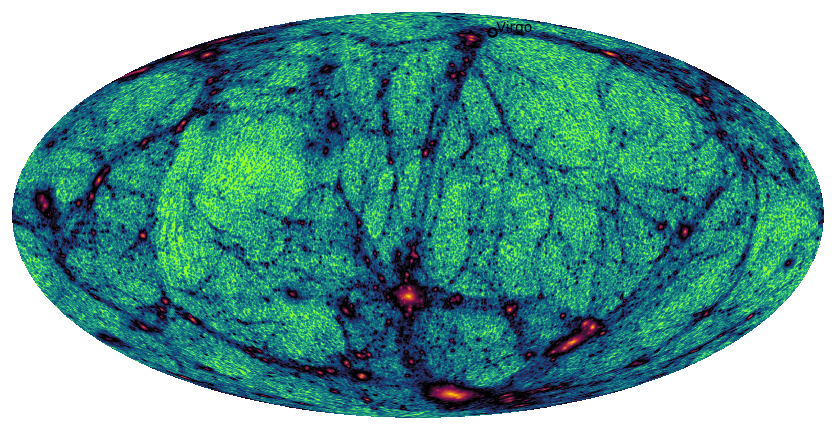

In [ ]:
cmap = cmr.wildfire
a = 0.025
z = np.arcsinh(view/ a)
# z = np.log10(view)
hp.mollview(z, cmap=cmap, title="", cbar=False, xsize=2400)
plt.tight_layout(pad=0.5)
# Overlay Virgo marker + label. lonlat=True expects (lon=l, lat=b) in degrees.
hp.projplot(l_virgo, b_virgo, lonlat=True, marker="o", ms=6, mfc="none", mec="k", mew=1.5)
hp.projtext(l_virgo, b_virgo, " Virgo", lonlat=True, size=10)
plt.savefig("/Users/rstiskalek/Downloads/test_map.png", dpi=500, bbox_inches="tight", pad_inches=0.05, )

In [ ]:
map_new = hp.sphtfunc.smoothing(ngpmap, fwhm=np.deg2rad(0.1
                                                        ))

In [ ]:
map_new.min()

np.float64(-739.781571753342)

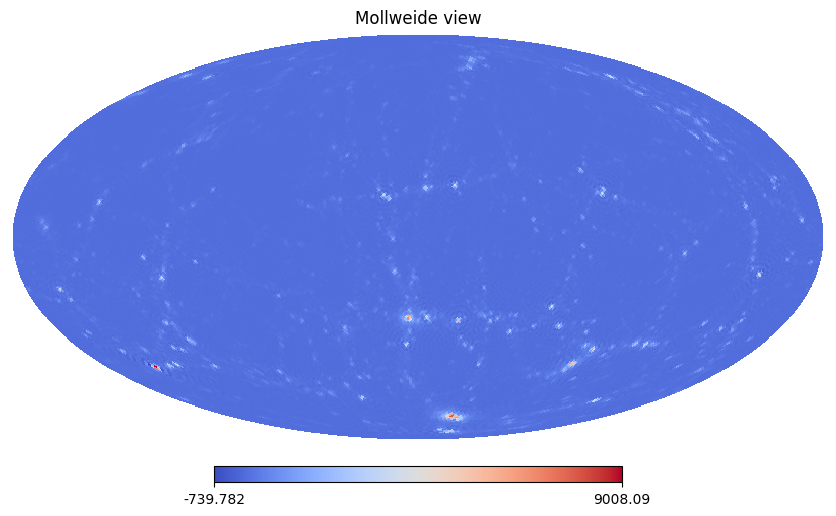

In [ ]:
hp.mollview(map_new, cmap="coolwarm",)

In [ ]:
def _to_delta(counts, eps=1e-12):
    mu = counts.mean()
    return counts / (mu + eps) - 1.0


def smooth_counts(counts, fwhm_arcmin, mask=None, remove_md=True):
    """
    counts: NGP (or weighted) counts, shape (12*nside^2,)
    fwhm_arcmin: Gaussian FWHM (arcmin)
    mask: optional 0/1 footprint; if None assumes full-sky
    """
    counts = np.asarray(counts, dtype=np.float64)
    nside = hp.npix2nside(len(counts))

    # Build δ on the unmasked sky
    if mask is None:
        mask = np.ones_like(counts, dtype=np.float64)
    good = mask > 0
    mean = counts[good].mean()
    if not np.isfinite(mean) or mean <= 0:
        raise ValueError("Non-positive mean count over unmasked pixels.")
    delta = np.zeros_like(counts)
    delta[good] = counts[good] / mean - 1.0

    # Protect masked region during mono/dipole fit, then fill with 0 for full-sky ops
    work = delta.copy()
    if remove_md:
        tmp = work.copy()
        tmp[~good] = hp.UNSEEN
        tmp = hp.remove_monopole(tmp)  # returns just the map
        tmp = hp.remove_dipole(tmp)
        work = np.where(good, tmp, 0.0)
    else:
        work[~good] = 0.0

    # Smooth with *FWHM* in radians (not sigma!)
    fwhm_rad = (fwhm_arcmin / 60.0) * (np.pi / 180.0)
    lmax = 3 * nside - 1
    alm = hp.map2alm(work, lmax=lmax, iter=0)
    bl = hp.gauss_beam(fwhm=fwhm_rad, lmax=lmax)  # <-- FWHM
    hp.almxfl(alm, bl, inplace=True)
    m_smooth = hp.alm2map(alm, nside, verbose=False)

    # Keep the footprint
    m_smooth *= mask
    return m_smooth

In [ ]:
map_smooth = smooth_counts(ngpmap, fwhm_arcmin=60.0, remove_md=True)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12514/2654799274.py:42: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  m_smooth = hp.alm2map(alm, nside, verbose=False)


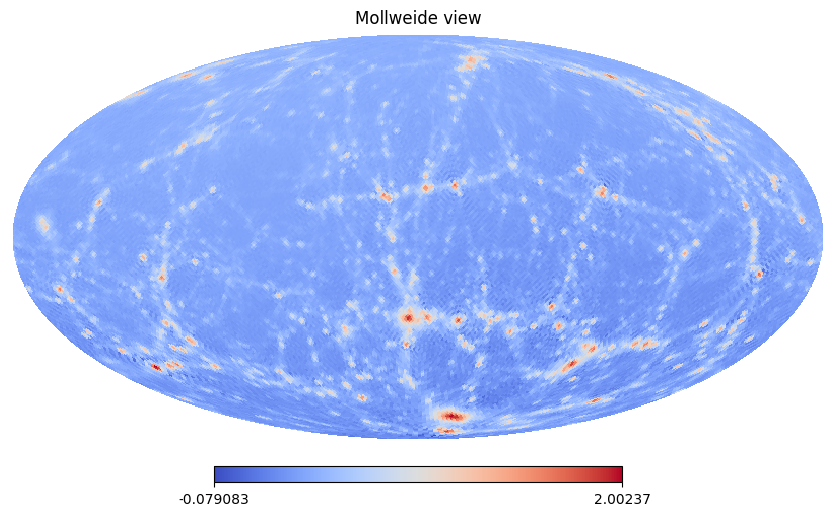

In [ ]:
hp.mollview(np.log10(3 + map_smooth), cmap="coolwarm",)

In [ ]:
map_smooth.min()

np.float64(-2.1664780895182463)

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_12514/2062381396.py:1: RuntimeWarning: invalid value encountered in log10
  hp.mollview(np.log10(map_smooth), cmap="coolwarm")


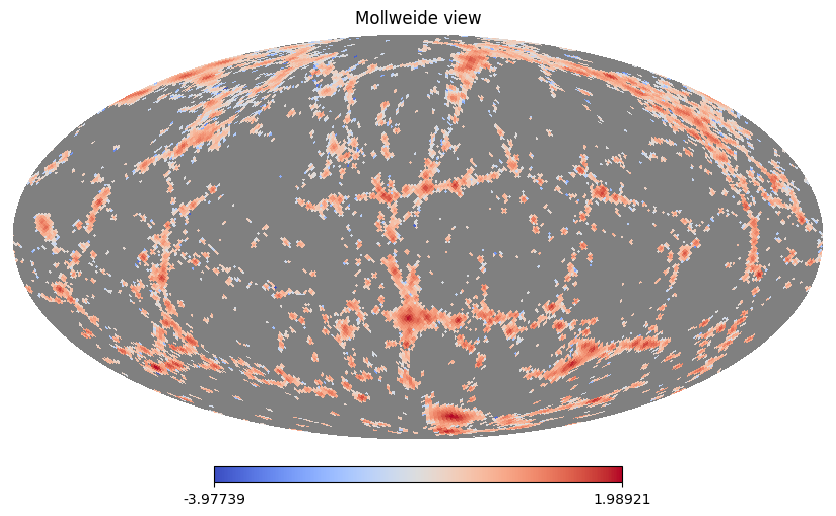

In [ ]:
hp.mollview(np.log10(map_smooth), cmap="coolwarm")

In [ ]:
ga

In [ ]:
import numpy as np
import healpy as hp
from tqdm import trange


def _minimal_image(rel, boxsize):
    if boxsize is None:
        return rel
    return rel - boxsize * np.round(rel / boxsize)


def _bincount_hp(theta, phi, w, nside, chunk=5_000_000):
    npix = hp.nside2npix(nside)
    out = np.zeros(npix, dtype=np.float64)
    n = theta.size
    for i in trange(0, n, chunk):
        sl = slice(i, min(i + chunk, n))
        pix = hp.ang2pix(nside, theta[sl], phi[sl])
        out += np.bincount(pix, weights=w[sl], minlength=npix)
    return out


def _to_delta(counts, eps=1e-12):
    mu = counts.mean()
    return counts / (mu + eps) - 1.0


def project_positions_to_healpix(
    pos,                      # (N, 3) array, same units as boxsize
    boxsize,                  # float, periodic box length
    nside=1024,
    rmax=None,                # default: boxsize/2
    weights=None,             # None -> ones
    scheme="oversample",      # 'ngp' | 'oversample' | 'beam'
    oversample_factor=4,      # for 'oversample'
    fwhm_arcmin=None,         # for 'beam' (or pass bl)
    bl=None,                  # custom B_ell (len lmax+1)
):
    origin = 0.5 * np.array([boxsize, boxsize, boxsize], dtype=np.float64)
    rel = _minimal_image(pos - origin, boxsize)
    r = np.linalg.norm(rel, axis=1)

    if rmax is None:
        rmax = 0.5 * boxsize

    m = (r > 0.0) & (r <= rmax)
    if not np.any(m):
        raise ValueError("No tracers within rmax.")

    rel = rel[m]
    r = r[m]
    w = np.ones(r.size, dtype=np.float64) if weights is None else weights[m]

    z = rel[:, 2]
    theta = np.arccos(np.clip(z / r, -1.0, 1.0))
    phi = np.mod(np.arctan2(rel[:, 1], rel[:, 0]), 2.0 * np.pi)

    if scheme == "ngp":
        counts = _bincount_hp(theta, phi, w, nside)
        return _to_delta(counts)

    if scheme == "oversample":
        nside_hi = nside * int(oversample_factor)
        counts_hi = _bincount_hp(theta, phi, w, nside_hi)
        counts = hp.ud_grade(counts_hi, nside_out=nside, power=True)
        return _to_delta(counts)

    if scheme == "beam":
        counts = _bincount_hp(theta, phi, w, nside)
        mdelta = _to_delta(counts)
        lmax = 3 * nside - 1
        alm = hp.map2alm(mdelta, lmax=lmax)
        if bl is None:
            if fwhm_arcmin is None:
                raise ValueError("Provide fwhm_arcmin or bl for 'beam'.")
            sigma = (np.deg2rad(fwhm_arcmin / 60.0) /
                     np.sqrt(8.0 * np.log(2.0)))
            bl = hp.gauss_beam(sigma, lmax=lmax)
        alm = hp.almxfl(alm, bl)
        return hp.alm2map(alm, nside, verbose=False)

    raise ValueError("scheme must be 'ngp', 'oversample', or 'beam'.")

In [ ]:
L = r.header["BoxSize"]

# pos: (N,3) in Mpc/h, boxsize in same units
delta2 = project_positions_to_healpix(
    pos=pos, boxsize=L, nside=1024, rmax=200.0,
    weights=None, scheme="ngp", fwhm_arcmin=500,
)

100%|██████████| 88/88 [00:23<00:00,  3.79it/s]


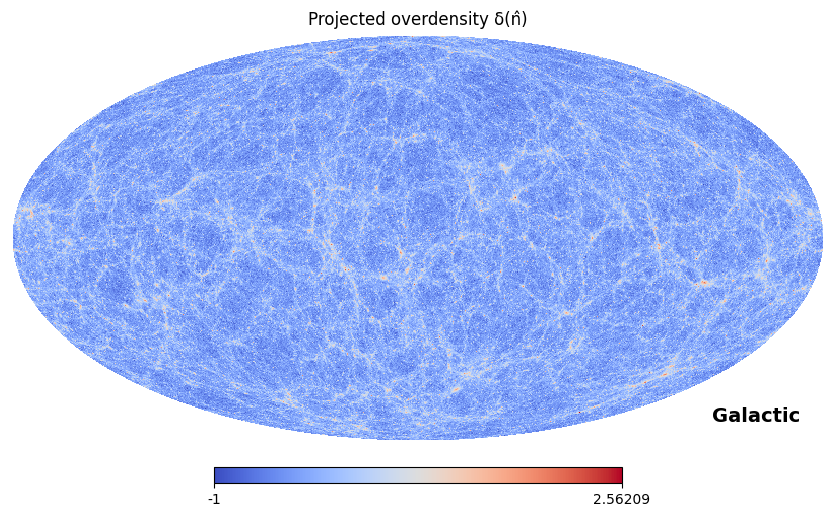

In [ ]:
# x = np.log10(1 + delta)
x = delta2

# vmin = np.percentile(x, 0.1)
# vmax = np.percentile(x, 99.5)
vmin = None
vmax = None


# Suppose delta is your overdensity map at some nside
hp.mollview(np.log10(1. + 1e-1 + x), coord=['G'], cmap="coolwarm",
            title="Projected overdensity δ(n̂)", min=vmin, max=vmax)

plt.show()

In [ ]:
def xcl_quick(m1, m2, mask=None, lmax=None, deconvolve_pixwin=True):
    nside = hp.get_nside(m1)
    assert hp.get_nside(m2) == nside
    if lmax is None:
        lmax = 3 * nside - 1

    if mask is None:
        mask = np.ones_like(m1, dtype=float)
    m1m = np.where(np.isfinite(m1), m1, 0.0) * mask
    m2m = np.where(np.isfinite(m2), m2, 0.0) * mask

    cl = hp.anafast(m1m, map2=m2m, lmax=lmax)
    fsky = mask.mean()
    cl /= fsky  # crude correction

    if deconvolve_pixwin:
        pw = hp.pixwin(nside, lmax=lmax)
        cl /= pw**2

    ells = np.arange(cl.size)
    return ells, cl

In [ ]:
ell, cl = xcl_quick(delta, -delta2)

In [ ]:
cl

array([-2.26646260e-14, -1.40279582e-02, -1.25202834e-02, ...,
       -5.08667120e-17,  4.48088679e-17, -5.09209800e-17], shape=(3072,))

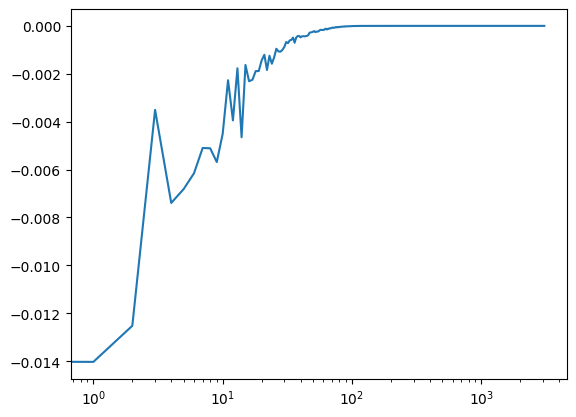

In [ ]:
plt.figure()
plt.plot(ell, cl)

# plt.yscale("log")
plt.xscale("log")

# plt.ylim(1e-4)

plt.show()


In [ ]:
aa